# TO PREDICT THE PROBABLITY OF DEFAULT OF CREDIT CARD CLIENTS

# ATTRIBUTES DESCRIPTION:


X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows:

X6 = The repayment status in September, 2005.

X7 = The repayment status in August, 2005.

....

X11 = The repayment status in April, 2005.

The measurement scale for the repayment status is:
(-2 = No consumption; -1 = Paid in full; 0 = The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; .... 8 = payment delay for eight months; 9 = payment delay for nine months and above).

X12-X17: Amount of bill statement (NT dollar).

X12 = Amount of bill statement in September, 2005.

X13 = Amount of bill statement in August, 2005.

....

X17 = Amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar).

X18 = Amount paid in September, 2005.

X19 = Amount paid in August, 2005.

....

X23 = Amount paid in April, 2005.

# IMPORTING THE LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTENC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# LOAD THE DATASET AND RESETTING IT TO PROPER TABLE

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
df = pd.read_excel('default of credit card clients.xls')

In [4]:
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [5]:
df.columns = df.iloc[0]

In [6]:
df = df.drop(0)

In [7]:
df = df.reset_index(drop = True)

In [8]:
df = df.rename(columns = {'default payment next month' : 'DEFAULT', 'PAY_0' : 'PAY_1'})

In [9]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
df.shape

(30000, 25)

# DATA PREPROCESSING

# ROWS THAT HAVE MEANINGLESS VALUES

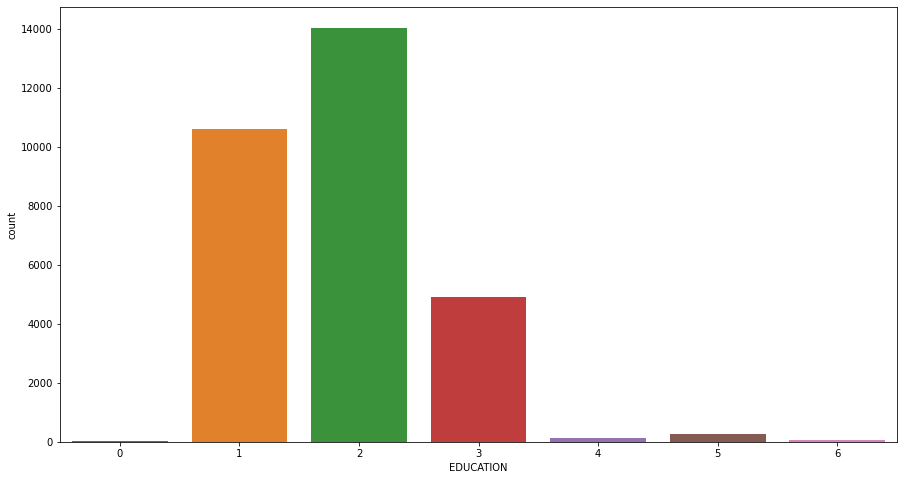

In [11]:
plt.figure(figsize= (15,8))
sns.countplot(df['EDUCATION'])
plt.show()

## In this column 0,5,6 makes no sense and doesn't represent anything

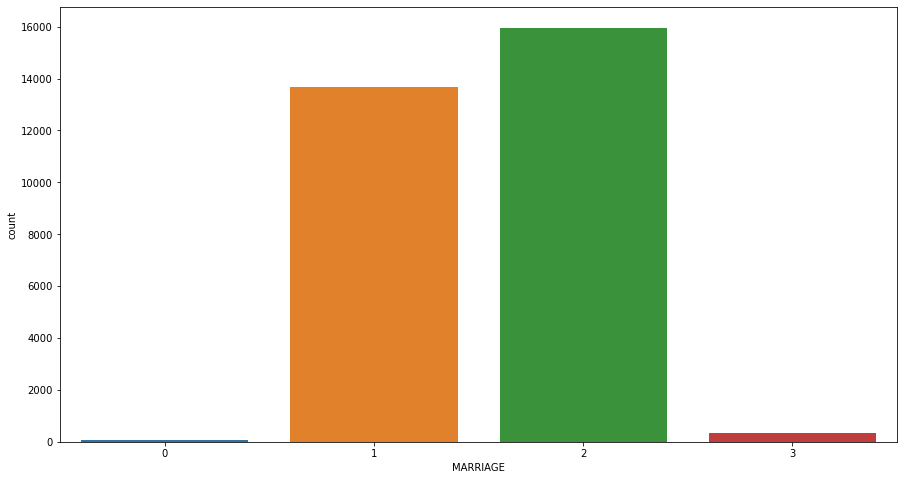

In [12]:
plt.figure(figsize= (15,8))
sns.countplot(df['MARRIAGE'])
plt.show()

## Here 0 makes no sense, hence removed

In [13]:
fill = (df.EDUCATION == 5) | (df.EDUCATION == 0) | (df.EDUCATION == 6) 
df.loc[fill,'EDUCATION'] = 2

In [14]:
df.EDUCATION.value_counts()

2    14375
1    10585
3     4917
4      123
Name: EDUCATION, dtype: int64

In [15]:
fill = (df.MARRIAGE == 0) 
df.loc[fill,'MARRIAGE'] = 2

In [16]:
df.MARRIAGE.value_counts()

2    16018
1    13659
3      323
Name: MARRIAGE, dtype: int64

In [17]:
df = df.drop(['ID'], 1)

ID column is not a significant feature. Hence dropped.

In [18]:
df.shape

(30000, 24)

# CONVERSION OF COLUMNS TO APPROPRIATE DATATYPE

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LIMIT_BAL  30000 non-null  object
 1   SEX        30000 non-null  object
 2   EDUCATION  30000 non-null  object
 3   MARRIAGE   30000 non-null  object
 4   AGE        30000 non-null  object
 5   PAY_1      30000 non-null  object
 6   PAY_2      30000 non-null  object
 7   PAY_3      30000 non-null  object
 8   PAY_4      30000 non-null  object
 9   PAY_5      30000 non-null  object
 10  PAY_6      30000 non-null  object
 11  BILL_AMT1  30000 non-null  object
 12  BILL_AMT2  30000 non-null  object
 13  BILL_AMT3  30000 non-null  object
 14  BILL_AMT4  30000 non-null  object
 15  BILL_AMT5  30000 non-null  object
 16  BILL_AMT6  30000 non-null  object
 17  PAY_AMT1   30000 non-null  object
 18  PAY_AMT2   30000 non-null  object
 19  PAY_AMT3   30000 non-null  object
 20  PAY_AMT4   30000 non-null  o

In [20]:
df[['LIMIT_BAL','AGE',
    'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
    'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']] = df[['LIMIT_BAL','AGE',
                                                                              'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                                                                              'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].astype('int')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LIMIT_BAL  30000 non-null  int64 
 1   SEX        30000 non-null  object
 2   EDUCATION  30000 non-null  object
 3   MARRIAGE   30000 non-null  object
 4   AGE        30000 non-null  int64 
 5   PAY_1      30000 non-null  object
 6   PAY_2      30000 non-null  object
 7   PAY_3      30000 non-null  object
 8   PAY_4      30000 non-null  object
 9   PAY_5      30000 non-null  object
 10  PAY_6      30000 non-null  object
 11  BILL_AMT1  30000 non-null  int64 
 12  BILL_AMT2  30000 non-null  int64 
 13  BILL_AMT3  30000 non-null  int64 
 14  BILL_AMT4  30000 non-null  int64 
 15  BILL_AMT5  30000 non-null  int64 
 16  BILL_AMT6  30000 non-null  int64 
 17  PAY_AMT1   30000 non-null  int64 
 18  PAY_AMT2   30000 non-null  int64 
 19  PAY_AMT3   30000 non-null  int64 
 20  PAY_AMT4   30000 non-null  i

# SPLITTING THE DATA INTO NUMERICAL AND CATEGORICAL

In [22]:
num_df = df.select_dtypes(include = np.number)
cat_df = df.select_dtypes(exclude = np.number)

In [23]:
num_df.describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [24]:
cat_df.describe()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,DEFAULT
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,2,4,3,11,11,11,11,10,10,2
top,2,2,2,0,0,0,0,0,0,0
freq,18112,14375,16018,14737,15730,15764,16455,16947,16286,23364


# MISSING VALUE ANALYSIS

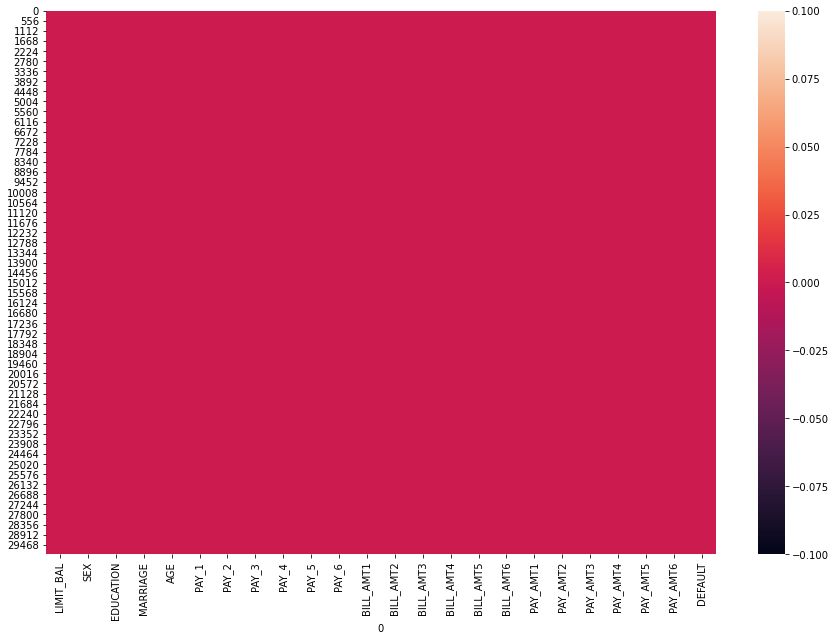

In [25]:
plt.figure(figsize = (15,10))
sns.heatmap(df.isnull(), cbar = True)

plt.show()

In [26]:
df.isnull().sum() / len(df)

0
LIMIT_BAL    0.0
SEX          0.0
EDUCATION    0.0
MARRIAGE     0.0
AGE          0.0
PAY_1        0.0
PAY_2        0.0
PAY_3        0.0
PAY_4        0.0
PAY_5        0.0
PAY_6        0.0
BILL_AMT1    0.0
BILL_AMT2    0.0
BILL_AMT3    0.0
BILL_AMT4    0.0
BILL_AMT5    0.0
BILL_AMT6    0.0
PAY_AMT1     0.0
PAY_AMT2     0.0
PAY_AMT3     0.0
PAY_AMT4     0.0
PAY_AMT5     0.0
PAY_AMT6     0.0
DEFAULT      0.0
dtype: float64

No missing values in this data.

# OUTLIER DETECTION

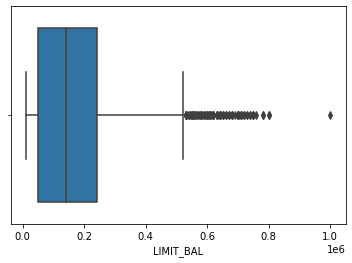

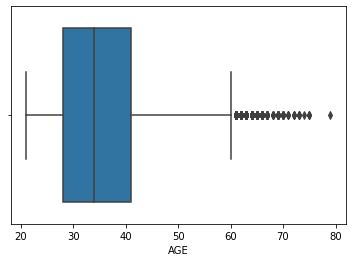

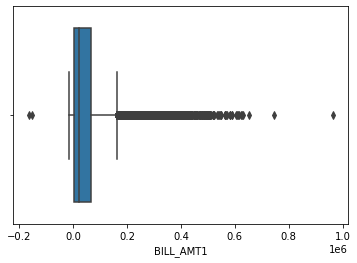

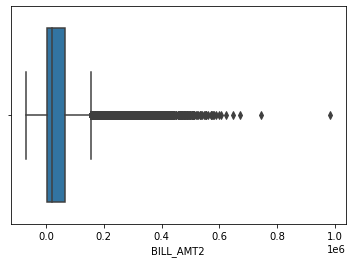

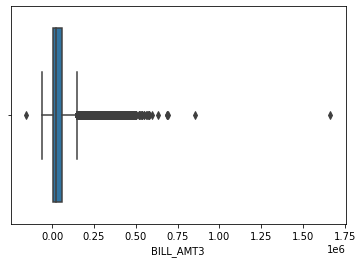

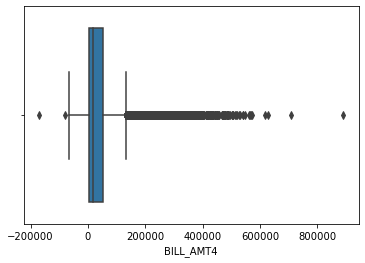

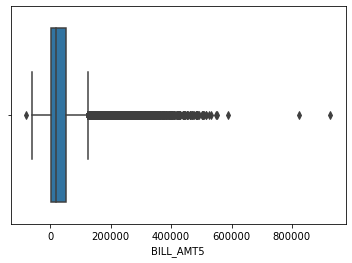

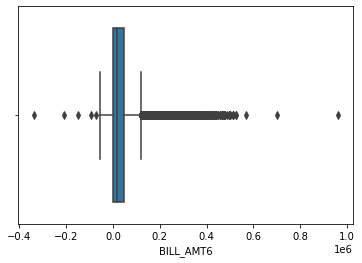

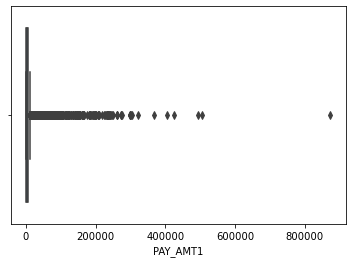

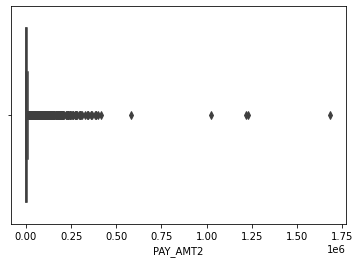

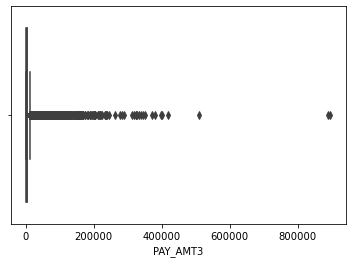

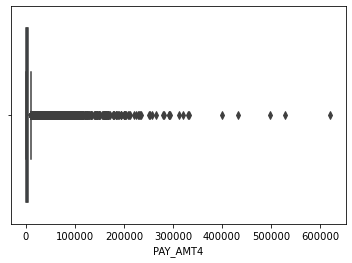

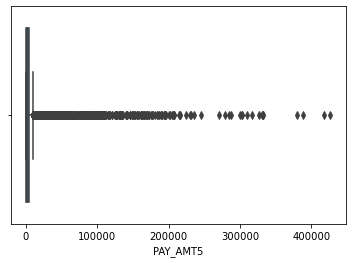

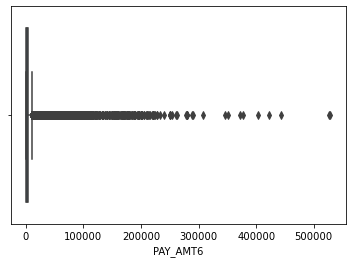

In [27]:
for i in num_df.columns:
    sns.boxplot(num_df[i])
    plt.show()

In [28]:
for i in num_df.columns:
    Q1 = num_df[i].quantile(0.25)
    Q3 = num_df[i].quantile(0.75)
    
    IQR = Q3 - Q1
    
    ub = Q3 + 1.5 * IQR
    lb = Q1 - 1.5 * IQR
    
    print('The number of outliers in ',i, ' is ',len(num_df[((num_df[i] > ub) | (num_df[i] < lb))]))

The number of outliers in  LIMIT_BAL  is  167
The number of outliers in  AGE  is  272
The number of outliers in  BILL_AMT1  is  2400
The number of outliers in  BILL_AMT2  is  2395
The number of outliers in  BILL_AMT3  is  2469
The number of outliers in  BILL_AMT4  is  2622
The number of outliers in  BILL_AMT5  is  2725
The number of outliers in  BILL_AMT6  is  2693
The number of outliers in  PAY_AMT1  is  2745
The number of outliers in  PAY_AMT2  is  2714
The number of outliers in  PAY_AMT3  is  2598
The number of outliers in  PAY_AMT4  is  2994
The number of outliers in  PAY_AMT5  is  2945
The number of outliers in  PAY_AMT6  is  2958


Even though there are large number of outliers, we cannot treat the outliers as they are significant and according to the domain, it is possible to have outliers in the bill amount and payment amount.

# STATISTICAL TEST

In [29]:
# Checking Statistical significance of independent categorical variables with Target: 

for i in df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]: 
    print("\033[1m" + "Hypothesis Formation:" + "\033[0m")
    print("Null Hypothesis (Ho):",i,"and DEFAULT are independent")
    print("Alternate Hypothesis (Ha):",i,"and DEFAULT are dependent")
    print()
    
    obs = pd.crosstab(df[i], df['DEFAULT']) 
    test_stat, pval, dof, exp = stats.chi2_contingency(obs)
    
    print("\033[1m" + "Statistical Significance of relationship between",i,"and DEFAULT:" + "\033[0m") 
    print("Test Statistics: ", test_stat)
    print("pValue: ", pval) 
    print("Degrees of freedom: ", dof) 
    print("\n***************************************************************************************************\n")

Hypothesis Formation:
Null Hypothesis (Ho): SEX and DEFAULT are independent
Alternate Hypothesis (Ha): SEX and DEFAULT are dependent

Statistical Significance of relationship between SEX and DEFAULT:
Test Statistics:  47.70879689062111
pValue:  4.944678999412044e-12
Degrees of freedom:  1

***************************************************************************************************

Hypothesis Formation:
Null Hypothesis (Ho): EDUCATION and DEFAULT are independent
Alternate Hypothesis (Ha): EDUCATION and DEFAULT are dependent

Statistical Significance of relationship between EDUCATION and DEFAULT:
Test Statistics:  109.30136242385805
pValue:  1.5512571274062487e-23
Degrees of freedom:  3

***************************************************************************************************

Hypothesis Formation:
Null Hypothesis (Ho): MARRIAGE and DEFAULT are independent
Alternate Hypothesis (Ha): MARRIAGE and DEFAULT are dependent

Statistical Significance of relationship between MAR

Inference: 
    
    ==>  From the results of statistical significance analysis of independent categorical variables with target using Chi-Square Test for Independence, we could see the pValue from all the statistical analysis is less than the significance level of 5% (0.05). 
    
    ==>  Hence Null hypothesis (Ho) is rejected and Alternate Hypothesis (Ha) can be selected. Thus, it is evident that all the independent categorical variables have significant relationship with the target variable.

# CONDITION CHECK FOR ANOVA TEST

### NORMALITY CHECK

In [30]:
a0 = df[df['DEFAULT'] == 0]['LIMIT_BAL']
a1 = df[df['DEFAULT'] == 1]['LIMIT_BAL']

b0 = df[df['DEFAULT'] == 0]['AGE']
b1 = df[df['DEFAULT'] == 1]['AGE']

In [31]:
c0 = df[df['DEFAULT'] == 0]['BILL_AMT1']
c1 = df[df['DEFAULT'] == 1]['BILL_AMT1']

d0 = df[df['DEFAULT'] == 0]['BILL_AMT2']
d1 = df[df['DEFAULT'] == 1]['BILL_AMT2']

e0 = df[df['DEFAULT'] == 0]['BILL_AMT3']
e1 = df[df['DEFAULT'] == 1]['BILL_AMT3']

f0 = df[df['DEFAULT'] == 0]['BILL_AMT4']
f1 = df[df['DEFAULT'] == 1]['BILL_AMT4']

g0 = df[df['DEFAULT'] == 0]['BILL_AMT5']
g1 = df[df['DEFAULT'] == 1]['BILL_AMT5']

h0 = df[df['DEFAULT'] == 0]['BILL_AMT6']
h1 = df[df['DEFAULT'] == 1]['BILL_AMT6']

In [32]:
i0 = df[df['DEFAULT'] == 0]['PAY_AMT1']
i1 = df[df['DEFAULT'] == 1]['PAY_AMT1']

j0 = df[df['DEFAULT'] == 0]['PAY_AMT2']
j1 = df[df['DEFAULT'] == 1]['PAY_AMT2']

k0 = df[df['DEFAULT'] == 0]['PAY_AMT3']
k1 = df[df['DEFAULT'] == 1]['PAY_AMT3']

l0 = df[df['DEFAULT'] == 0]['PAY_AMT4']
l1 = df[df['DEFAULT'] == 1]['PAY_AMT4']

m0 = df[df['DEFAULT'] == 0]['PAY_AMT5']
m1 = df[df['DEFAULT'] == 1]['PAY_AMT5']

n0 = df[df['DEFAULT'] == 0]['PAY_AMT6']
n1 = df[df['DEFAULT'] == 1]['PAY_AMT6']

In [33]:
# Test of Normality 

# Ho: skew = 0
# Ha: skew != 0

print("Shapiro result for a0:",stats.shapiro(a0))
print("Shapiro result for a1:",stats.shapiro(a1))
print("Shapiro result for b0:",stats.shapiro(b0))
print("Shapiro result for b1:",stats.shapiro(b1))
print("Shapiro result for c0:",stats.shapiro(c0)) 
print("Shapiro result for c1",stats.shapiro(c1)) 
print("Shapiro result for d0:",stats.shapiro(d0)) 
print("Shapiro result for d1:",stats.shapiro(d1)) 
print("Shapiro result for e0:",stats.shapiro(e0))
print("Shapiro result for e1:",stats.shapiro(e1))
print("Shapiro result for f0:",stats.shapiro(f0))
print("Shapiro result for f1:",stats.shapiro(f1))
print("Shapiro result for g0:",stats.shapiro(g0)) 
print("Shapiro result for g1",stats.shapiro(g1)) 
print("Shapiro result for h0:",stats.shapiro(h0)) 
print("Shapiro result for h1:",stats.shapiro(h1)) 
print("Shapiro result for i0:",stats.shapiro(i0))
print("Shapiro result for i1:",stats.shapiro(i1))
print("Shapiro result for j0:",stats.shapiro(j0))
print("Shapiro result for j1:",stats.shapiro(j1))
print("Shapiro result for k0:",stats.shapiro(k0)) 
print("Shapiro result for k1",stats.shapiro(k1)) 
print("Shapiro result for l0:",stats.shapiro(l0)) 
print("Shapiro result for l1:",stats.shapiro(l1)) 
print("Shapiro result for m0:",stats.shapiro(m0))
print("Shapiro result for m1:",stats.shapiro(m1))
print("Shapiro result for n0:",stats.shapiro(n0))
print("Shapiro result for n1:",stats.shapiro(n1))

Shapiro result for a0: ShapiroResult(statistic=0.9197262525558472, pvalue=0.0)
Shapiro result for a1: ShapiroResult(statistic=0.8549829721450806, pvalue=0.0)
Shapiro result for b0: ShapiroResult(statistic=0.9496142864227295, pvalue=0.0)
Shapiro result for b1: ShapiroResult(statistic=0.9501640200614929, pvalue=1.0733946236728099e-42)
Shapiro result for c0: ShapiroResult(statistic=0.7077071666717529, pvalue=0.0)
Shapiro result for c1 ShapiroResult(statistic=0.6597214341163635, pvalue=0.0)
Shapiro result for d0: ShapiroResult(statistic=0.7044762372970581, pvalue=0.0)
Shapiro result for d1: ShapiroResult(statistic=0.6616373062133789, pvalue=0.0)
Shapiro result for e0: ShapiroResult(statistic=0.6865330934524536, pvalue=0.0)
Shapiro result for e1: ShapiroResult(statistic=0.6634527444839478, pvalue=0.0)
Shapiro result for f0: ShapiroResult(statistic=0.6877426505088806, pvalue=0.0)
Shapiro result for f1: ShapiroResult(statistic=0.6591142416000366, pvalue=0.0)
Shapiro result for g0: ShapiroResu

Inference:

    ==> pValue of Shapiro Result for scores of different adverse effects < 0.05 (sig. lvl).
    
    ==> Hence, Ho is rejected and so data is not normal .

### VARIANCE CHECK

In [34]:
# Test for equality of variance 

# Ho: All variances are equal
# Ha: Atleast one variance is different 

print(stats.levene(a0,a1,b0,b1,c0,c1,d0,d1,e0,e1,f0,f1,g0,g1,h0,h1,i0,i1,j0,j1,k0,k1,l0,l1,m0,m1,n0,n1)) 

LeveneResult(statistic=5315.887946507826, pvalue=0.0)


Inference:

    ==> pValue of Levene Result for scores of different adverse effects < 0.05 (sig. lvl).
    
    ==> Hence, Ho is rejected and all variances are not equal. 

Since it doesn't satisfy both the conditions, we can't use ANOVA test here. Hence Non-Parametric test is used.

# NON-PARAMETRIC TEST (KRUSKAL TEST)

In [35]:
# Hypothesis for Kruskal: 

# Ho: All medians are equal
# Ha: Atleast one median is different

In [36]:
stats.kruskal(a0,a1,b0,b1,c0,c1,d0,d1,e0,e1,f0,f1,g0,g1,h0,h1,i0,i1,j0,j1,k0,k1,l0,l1,m0,m1,n0,n1)

KruskalResult(statistic=159267.7136315139, pvalue=0.0)

Inference:

    ==> pValue of Kruskal Result for scores of different adverse effects < 0.05 (sig. lvl) 
   
    ==> Hence, Ho is rejected and all medians are not equal. 

# BILL AMOUNT vs DEFAULT CREDIT CARD CUSTOMERS

In [37]:
df.groupby('DEFAULT')['BILL_AMT1'].sum() / df['BILL_AMT1'].sum() * 100

DEFAULT
0    79.052072
1    20.947928
Name: BILL_AMT1, dtype: float64

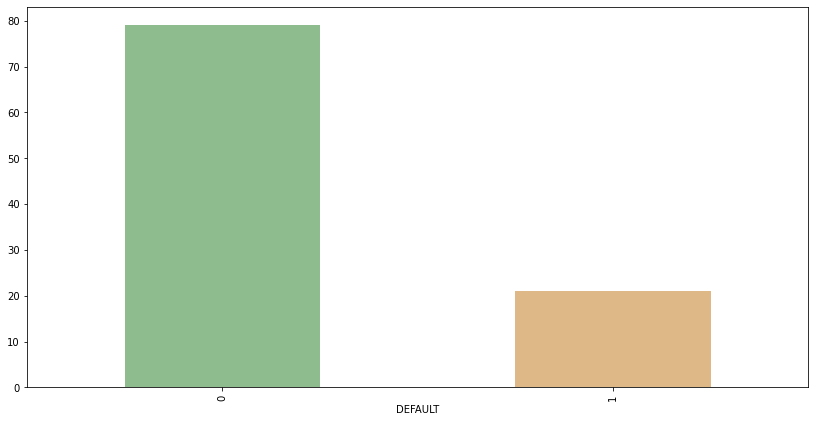

In [38]:
plt.figure(figsize = (14,7))
(df.groupby('DEFAULT')['BILL_AMT1'].sum() / df['BILL_AMT1'].sum() * 100).plot(kind = 'bar', color = ['darkseagreen','burlywood'])
plt.show()

In [39]:
df.groupby('DEFAULT')['BILL_AMT2'].sum() / df['BILL_AMT2'].sum() * 100

DEFAULT
0    78.732548
1    21.267452
Name: BILL_AMT2, dtype: float64

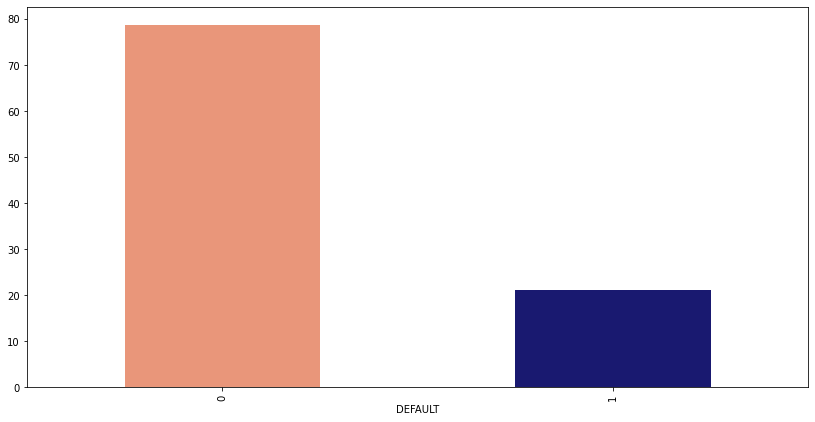

In [40]:
plt.figure(figsize = (14,7))
(df.groupby('DEFAULT')['BILL_AMT2'].sum() / df['BILL_AMT2'].sum() * 100).plot(kind = 'bar', color = ['darksalmon','midnightblue'])
plt.show()

In [41]:
df.groupby('DEFAULT')['BILL_AMT3'].sum() / df['BILL_AMT3'].sum() * 100

DEFAULT
0    78.741759
1    21.258241
Name: BILL_AMT3, dtype: float64

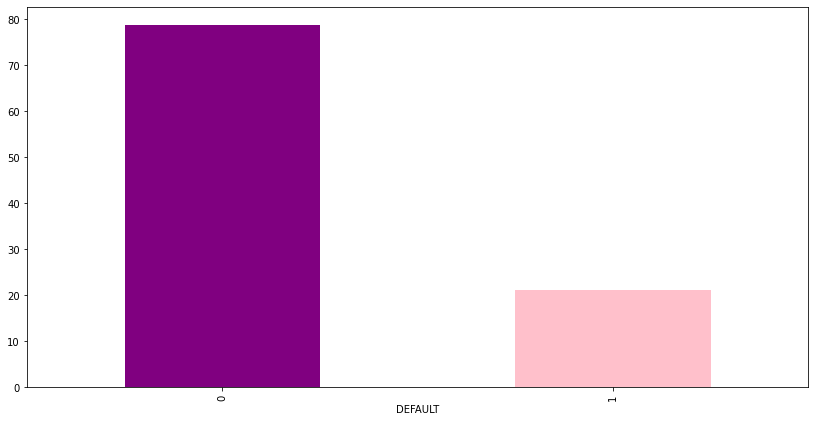

In [42]:
plt.figure(figsize = (14,7))
(df.groupby('DEFAULT')['BILL_AMT3'].sum() / df['BILL_AMT3'].sum() * 100).plot(kind = 'bar', color = ['purple','pink'])
plt.show()

In [43]:
df.groupby('DEFAULT')['BILL_AMT4'].sum() / df['BILL_AMT4'].sum() * 100

DEFAULT
0    78.506843
1    21.493157
Name: BILL_AMT4, dtype: float64

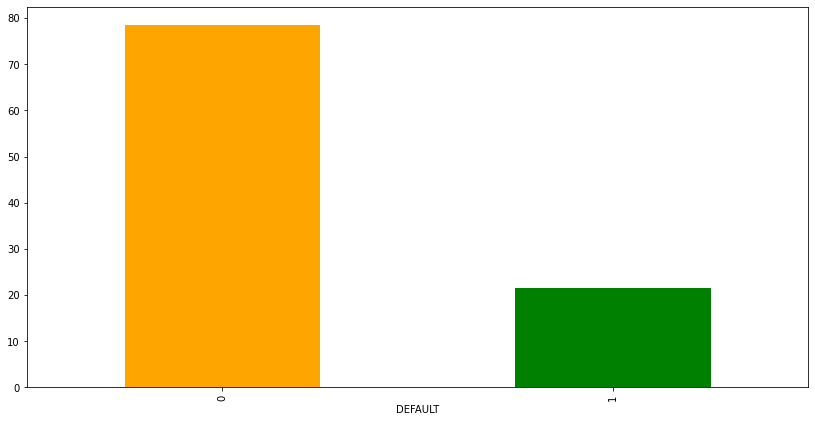

In [44]:
plt.figure(figsize = (14,7))
(df.groupby('DEFAULT')['BILL_AMT4'].sum() / df['BILL_AMT4'].sum() * 100).plot(kind = 'bar', color = ['orange','green'])
plt.show()

In [45]:
df.groupby('DEFAULT')['BILL_AMT5'].sum() / df['BILL_AMT5'].sum() * 100

DEFAULT
0    78.303185
1    21.696815
Name: BILL_AMT5, dtype: float64

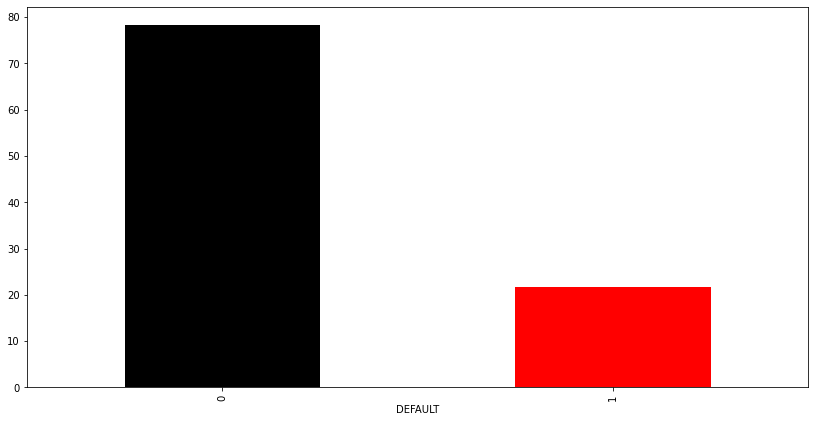

In [46]:
plt.figure(figsize = (14,7))
(df.groupby('DEFAULT')['BILL_AMT5'].sum() / df['BILL_AMT5'].sum() * 100).plot(kind = 'bar', color = ['black','red'])
plt.show()

In [47]:
df.groupby('DEFAULT')['BILL_AMT6'].sum() / df['BILL_AMT6'].sum() * 100

DEFAULT
0    78.221615
1    21.778385
Name: BILL_AMT6, dtype: float64

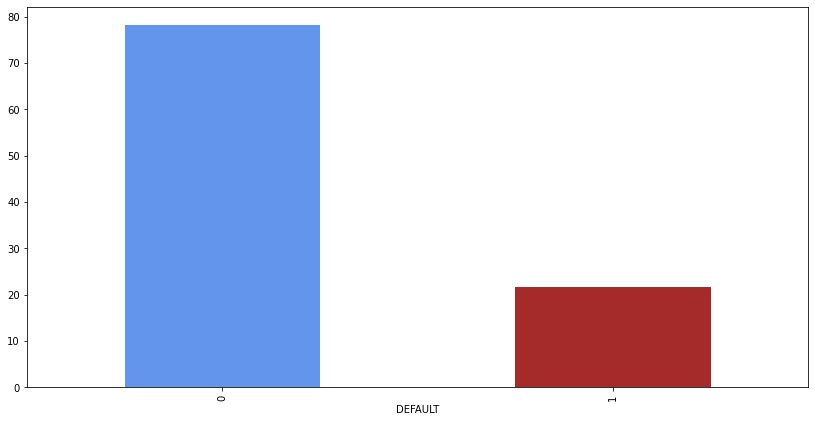

In [48]:
plt.figure(figsize = (14,7))
(df.groupby('DEFAULT')['BILL_AMT6'].sum() / df['BILL_AMT6'].sum() * 100).plot(kind = 'bar', color = ['cornflowerblue','brown'])
plt.show()

# DATA INTERPRETATION USING GRAPHS

## BIVARIATE ANALYSIS

### CREDIT LIMIT WITH SEX

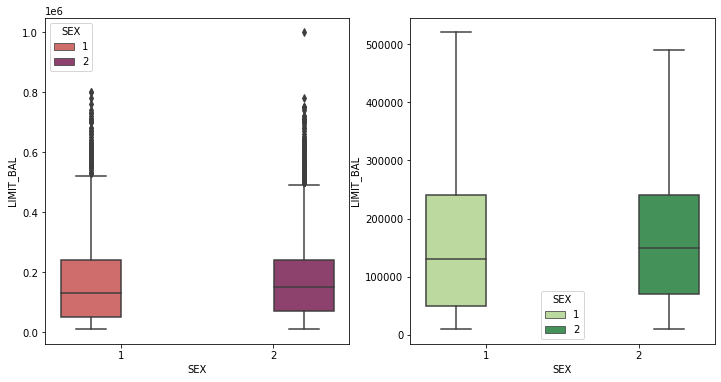

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,6))

s1 = sns.boxplot(ax = ax1, x = "SEX", y = "LIMIT_BAL", hue = "SEX", data = df, palette = "flare", showfliers = True)
s2 = sns.boxplot(ax = ax2, x = "SEX", y = "LIMIT_BAL", hue = "SEX", data = df, palette = "YlGn", showfliers = False)

plt.show()

## Credit Limit by Sex. The data is evenly distributed amongst males and females.

### AGE WITH MARRIAGE

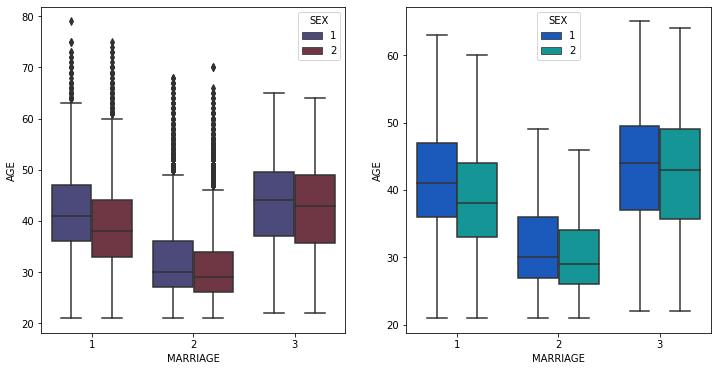

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,6))

s3 = sns.boxplot(ax = ax1, x = "MARRIAGE", y = "AGE", hue = "SEX", data = df, palette = "icefire", showfliers = True)
s4 = sns.boxplot(ax = ax2, x = "MARRIAGE", y = "AGE", hue = "SEX", data = df, palette = "winter", showfliers = False)

plt.show()

## The dataset mostly contains couples in their mid-30s to mid-40s and single people in their mid-20s to early-30s.

### EDUCATION WITH AGE

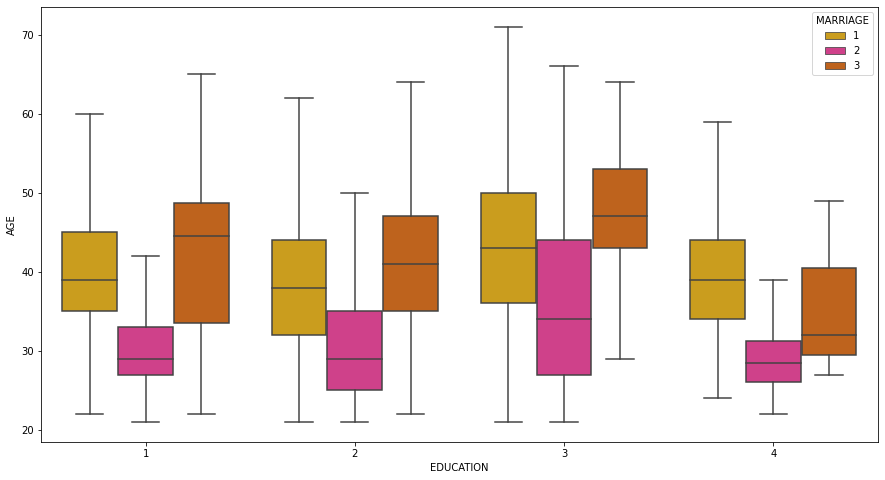

In [51]:
plt.figure(figsize = (15,8))
sns.boxplot(x = "EDUCATION", y = "AGE", hue = "MARRIAGE", data = df, palette = "Dark2_r", showfliers = False)

plt.show()

### AGE WITH LIMIT BALANCE

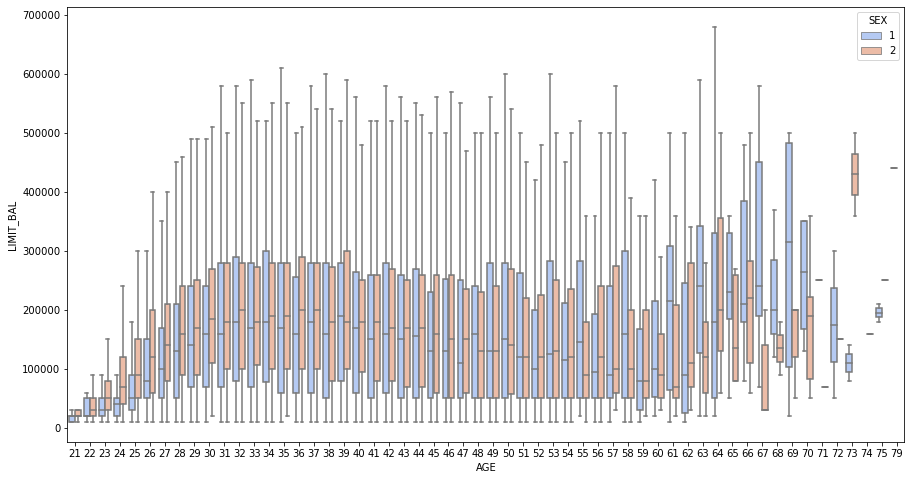

In [52]:
plt.figure(figsize = (15,8))
sns.boxplot(x = "AGE", y = "LIMIT_BAL", hue = "SEX", data = df, palette = "coolwarm", showfliers = False)

plt.show()

Mean, Q3 and Q4 values are increasing for both male and female with age until aroung 35 years and then they are oscilating and get to a maximum of Q4 for males at age 64.

Mean values are generally smaller for males than for females, with few exceptions, for example at age 39, 48, until approximately 60, where mean values for males are generally larger than for females.

### MARRIAGE WITH LIMIT BALANCE

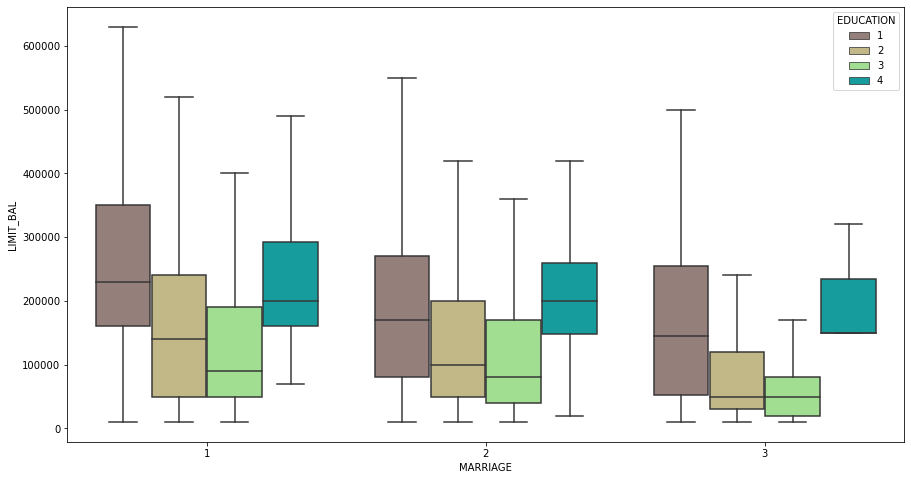

In [53]:
plt.figure(figsize = (15,8))
sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL", hue = "EDUCATION", data = df, palette = "terrain_r", showfliers = False)

plt.show()

### MAXIMUM LIMIT OF CREDIT CARD LIMIT AMOUNT

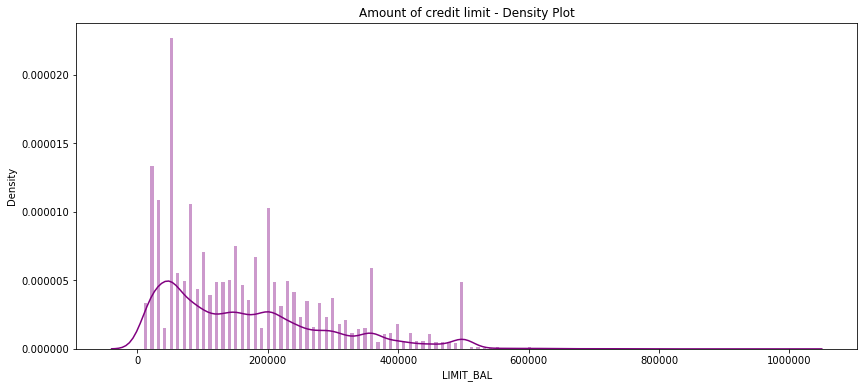

In [54]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')

sns.set_color_codes("pastel")

sns.distplot(df['LIMIT_BAL'], kde = True, bins = 200, color = "purple")
plt.ticklabel_format(useOffset = False, style = 'plain')

plt.show()

In [55]:
df[df['LIMIT_BAL'] > 50000].shape

(22324, 24)

In [56]:
df['LIMIT_BAL'].value_counts().head()

50000     3365
20000     1976
30000     1610
80000     1567
200000    1528
Name: LIMIT_BAL, dtype: int64

The largest number of credit cards are with limit of 50,000

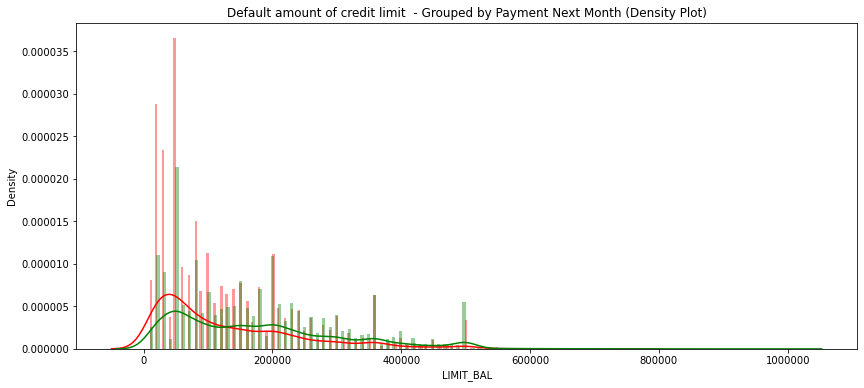

In [57]:
class_0 = df.loc[df['DEFAULT'] == 0]["LIMIT_BAL"]
class_1 = df.loc[df['DEFAULT'] == 1]["LIMIT_BAL"]

plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit  - Grouped by Payment Next Month (Density Plot)')

sns.set_color_codes("pastel")

sns.distplot(class_1, kde = True, bins = 200, color = "red")
sns.distplot(class_0, kde = True, bins = 200, color = "green")
plt.ticklabel_format(useOffset = False, style = 'plain')

plt.show()

# RELATIONSHIP BETWEEN INDEPENDENT AND TARGET VARIABLE

## CATEGORICAL FEATURES vs DEFAULT

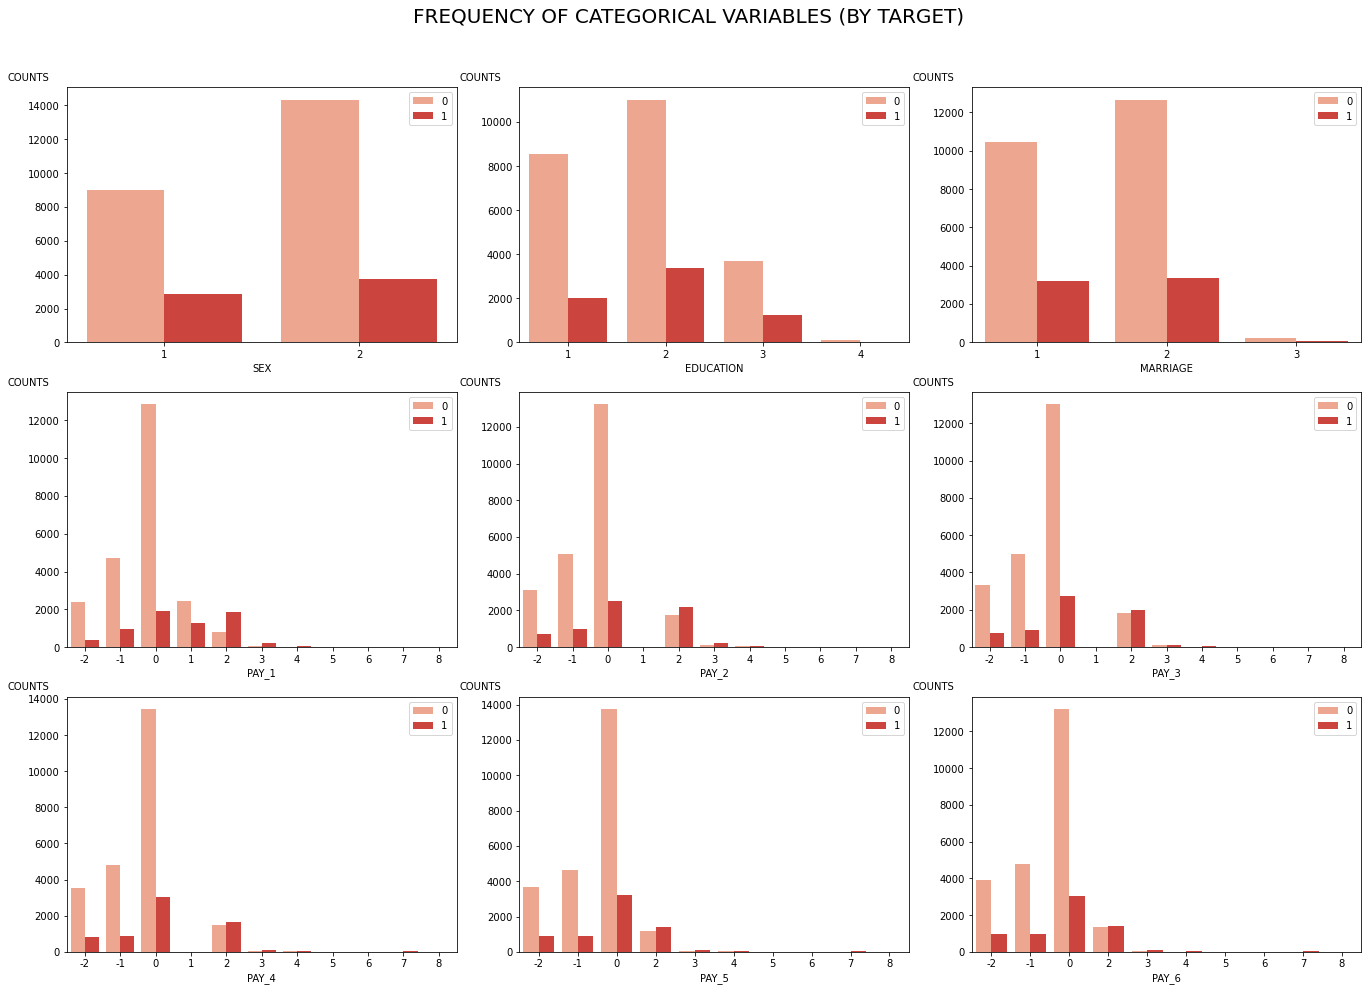

In [58]:
f, axes = plt.subplots(3, 3, figsize = (19,14), facecolor = 'white')
f.suptitle("FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)",size = 20)

# Creating plots of each categorical variable to target 
ax1 = sns.countplot(x = 'SEX', hue = 'DEFAULT', data = cat_df, palette ='Reds', ax = axes[0,0])
ax2 = sns.countplot(x = 'EDUCATION', hue = 'DEFAULT', data = cat_df, palette ='Reds', ax = axes[0,1])
ax3 = sns.countplot(x = 'MARRIAGE', hue = 'DEFAULT', data = cat_df, palette = 'Reds', ax = axes[0,2])
ax4 = sns.countplot(x = 'PAY_1', hue = 'DEFAULT', data = cat_df, palette = 'Reds', ax = axes[1,0])
ax5 = sns.countplot(x = 'PAY_2', hue = 'DEFAULT', data = cat_df, palette = 'Reds', ax = axes[1,1])
ax6 = sns.countplot(x = 'PAY_3', hue = 'DEFAULT', data = cat_df, palette = 'Reds', ax = axes[1,2])
ax7 = sns.countplot(x = 'PAY_4', hue = 'DEFAULT', data = cat_df, palette = 'Reds', ax = axes[2,0])
ax8 = sns.countplot(x = 'PAY_5', hue = 'DEFAULT', data = cat_df, palette = 'Reds', ax = axes[2,1])
ax9 = sns.countplot(x = 'PAY_6', hue = 'DEFAULT', data = cat_df, palette = 'Reds', ax = axes[2,2])

# Setting legends to upper right
ax1.legend(loc = "upper right")
ax2.legend(loc = "upper right")
ax3.legend(loc = "upper right")
ax4.legend(loc = "upper right")
ax5.legend(loc = "upper right")
ax6.legend(loc = "upper right")
ax7.legend(loc = "upper right")
ax8.legend(loc = "upper right")
ax9.legend(loc = "upper right")

# Changing ylabels to horizontal and changing their positions
ax1.set_ylabel('COUNTS', rotation = 0, labelpad = 40)  # Labelpad adjusts distance of the title from the graph
ax1.yaxis.set_label_coords(-0.1,1.02)              # (x, y)

ax2.set_ylabel('COUNTS', rotation = 0, labelpad = 40)
ax2.yaxis.set_label_coords(-0.1,1.02)

ax3.set_ylabel('COUNTS', rotation = 0, labelpad = 40)
ax3.yaxis.set_label_coords(-0.1,1.02)

ax4.set_ylabel('COUNTS', rotation = 0, labelpad = 40)
ax4.yaxis.set_label_coords(-0.1,1.02)

ax5.set_ylabel('COUNTS', rotation = 0, labelpad = 40)
ax5.yaxis.set_label_coords(-0.1,1.02)

ax6.set_ylabel('COUNTS', rotation = 0, labelpad = 40)
ax6.yaxis.set_label_coords(-0.1,1.02)

ax7.set_ylabel('COUNTS', rotation = 0, labelpad = 40)
ax7.yaxis.set_label_coords(-0.1,1.02)

ax8.set_ylabel('COUNTS', rotation = 0, labelpad = 40)
ax8.yaxis.set_label_coords(-0.1,1.02)

ax9.set_ylabel('COUNTS', rotation = 0, labelpad = 40)
ax9.yaxis.set_label_coords(-0.1,1.02)

# Shifting the Super Title higher
f.tight_layout()  # Prevents graphs from overlapping with each other
f.subplots_adjust(top = 0.9)

## FREQUENCY DISTRIBUTION

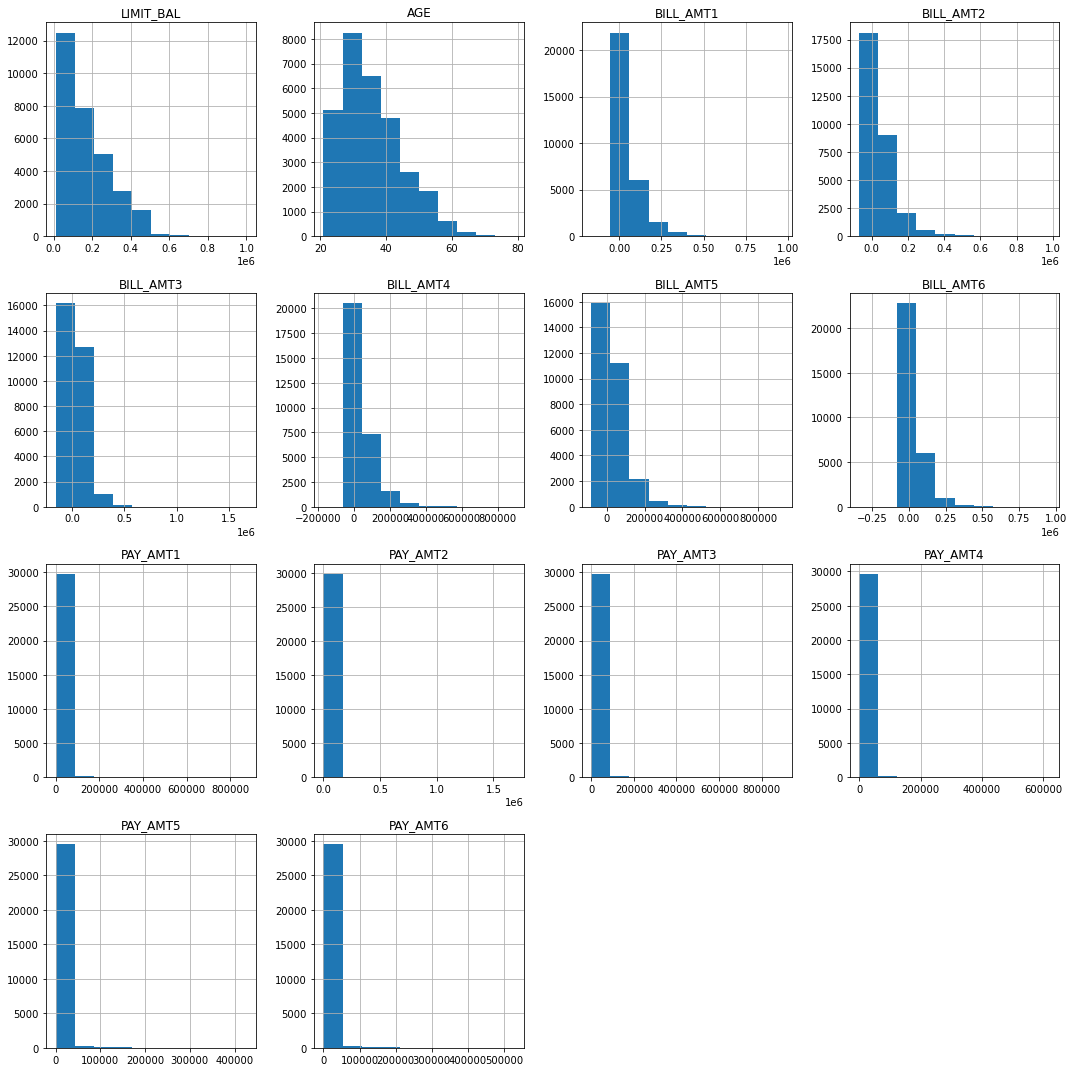

In [59]:
# Freq distribution of all data

fig, ax = plt.subplots(figsize = (15,15))
pd.DataFrame.hist(num_df,ax = ax)
plt.tight_layout();

# FEATURES CORRELATION

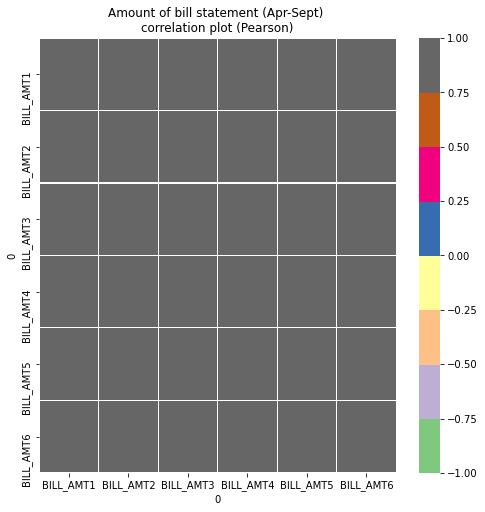

In [60]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')

corr = df[var].corr()

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = plt.cm.Accent, linewidths = .1, vmin = -1, vmax = 1)
plt.show()

Correlation is high for bill amounts between months.

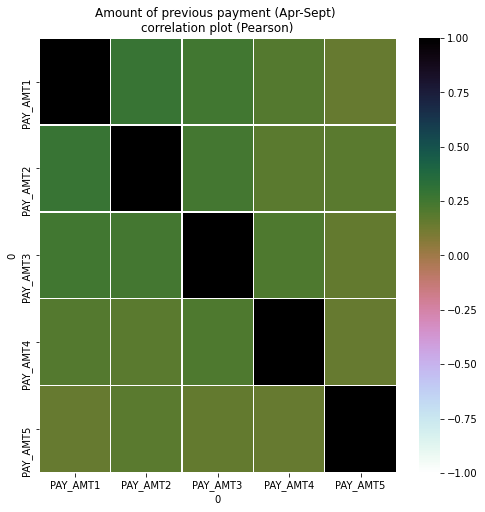

In [61]:
var1 = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (8,8))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')

corr = df[var1].corr()

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = plt.cm.cubehelix_r , linewidths = .1, vmin = -1, vmax = 1)
plt.show()

There is no correlation between amounts of previous payments for April-Sept 2005.

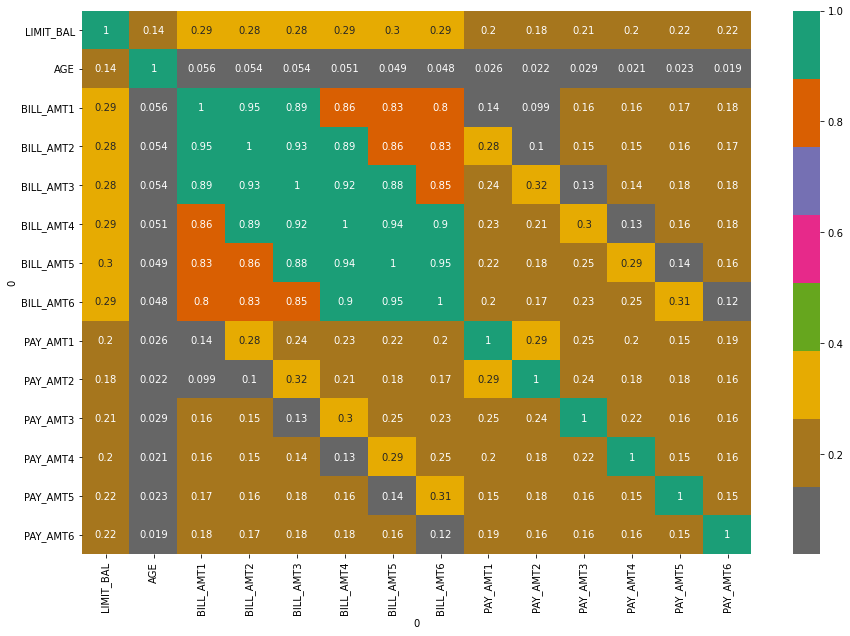

In [62]:
plt.figure(figsize = (15,10))
sns.heatmap(num_df.corr(),annot = True, cmap = plt.cm.Dark2_r)
plt.show()

# CLASS IMBALANCE

In [63]:
df['DEFAULT'].value_counts()

0    23364
1     6636
Name: DEFAULT, dtype: int64

In [64]:
df['DEFAULT'].value_counts(normalize = True)

0    0.7788
1    0.2212
Name: DEFAULT, dtype: float64

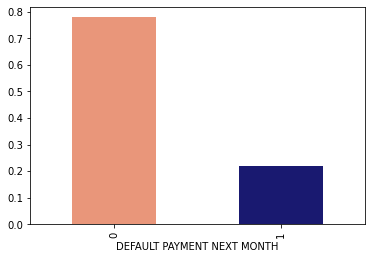

In [65]:
df['DEFAULT'].value_counts(normalize = True).plot(kind = 'bar', color = ['darksalmon','midnightblue'])
plt.xlabel('DEFAULT PAYMENT NEXT MONTH')
plt.show()

# PREDICTIVE MODELS

In [66]:
target = df['DEFAULT']

predictors = df.drop(['DEFAULT'], axis = 1)

# TRAIN TEST SPLIT

In [67]:
x_train, x_test, y_train, y_test = train_test_split(predictors,target, test_size = 0.3, random_state = 3, shuffle = True )

In [68]:
## Copying data for later usage

x_train_df = x_train.copy()
x_test_df = x_test.copy()
y_train_df = y_train.copy()
y_test_df = y_test.copy()

In [69]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(21000, 23)
(21000,)
(9000, 23)
(9000,)


# ONE HOT ENCODING

In [70]:
df['DEFAULT'] = df['DEFAULT'].astype('int')

In [71]:
cat_df1 = df.select_dtypes(exclude = np.number)

In [72]:
x_train_f_df = pd.get_dummies(x_train_df, columns = cat_df1.columns, drop_first = True)
x_test_f_df = pd.get_dummies(x_test_df, columns = cat_df1.columns, drop_first = True)

y_train_f_df = pd.get_dummies(y_train_df, columns = cat_df1.columns, drop_first = True)
y_test_f_df = pd.get_dummies(y_test_df, columns = cat_df1.columns, drop_first = True)

In [73]:
print("Default of Credit Card Clients xtrain data -  rows:",x_train_f_df.shape[0]," columns:", x_train_f_df.shape[1])
print("Default of Credit Card Clients xtest data -  rows:",x_test_f_df.shape[0]," columns:", x_test_f_df.shape[1])

print("Default of Credit Card Clients ytrain data -  rows:",y_train_f_df.shape[0]," columns:", y_train_f_df.shape[1])
print("Default of Credit Card Clients ytest data -  rows:",y_test_f_df.shape[0]," columns:", y_test_f_df.shape[1])

Default of Credit Card Clients xtrain data -  rows: 21000  columns: 78
Default of Credit Card Clients xtest data -  rows: 9000  columns: 72
Default of Credit Card Clients ytrain data -  rows: 21000  columns: 1
Default of Credit Card Clients ytest data -  rows: 9000  columns: 1


Columns are not equal. So we need to align them.

In [74]:
x_train_fa_df, x_test_fa_df = x_train_f_df.align(x_test_f_df, join = 'outer', axis = 1, fill_value = 0)
y_train_fa_df, y_test_fa_df = y_train_f_df.align(y_test_f_df, join = 'outer', axis = 1, fill_value = 0)

In [75]:
print("Default of Credit Card Clients xtrain data -  rows:",x_train_fa_df.shape[0]," columns:", x_train_fa_df.shape[1])
print("Default of Credit Card Clients xtest data -  rows:",x_test_fa_df.shape[0]," columns:", x_test_fa_df.shape[1])

print("Default of Credit Card Clients ytrain data -  rows:",y_train_fa_df.shape[0]," columns:", y_train_fa_df.shape[1])
print("Default of Credit Card Clients ytest data -  rows:",y_test_fa_df.shape[0]," columns:", y_test_fa_df.shape[1])

Default of Credit Card Clients xtrain data -  rows: 21000  columns: 78
Default of Credit Card Clients xtest data -  rows: 9000  columns: 78
Default of Credit Card Clients ytrain data -  rows: 21000  columns: 1
Default of Credit Card Clients ytest data -  rows: 9000  columns: 1


In [76]:
x_train_fa_df.head(2)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,LIMIT_BAL,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_2
25917,28,16094,2259,0,12880,14895,9386,0,0,0,300000,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2259,0,12880,2500,200,280,1
4494,42,5674,5440,7968,8829,9685,9384,0,1,0,10000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2800,1000,1000,0,1000,0


In [77]:
y_train_fa_df.head(2)

,1
25917,0
4494,1


In [78]:
x_test_fa_df.head(2)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,LIMIT_BAL,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_2
18210,42,0,1145,1000,2000,500,5305,1,0,0,210000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1145,1005,2000,500,5305,3640,0
5987,39,0,0,0,0,0,0,0,1,0,360000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [79]:
y_test_fa_df.head(2)

,1
18210,0
5987,1


# SMOTE-NC ALGORITHM FOR IMBALANCED CLASS

In [80]:
df['DEFAULT'] = df['DEFAULT'].astype('object')

In [81]:
sm = SMOTENC(categorical_features = [df.dtypes == object], random_state = 3)

In [82]:
x_train_sm, y_train_sm = sm.fit_resample(x_train_fa_df, y_train_fa_df)

In [83]:
print(x_train_sm.shape)
print(y_train_sm.shape)

print(x_test_fa_df.shape)
print(y_test_fa_df.shape)

(32554, 78)
(32554, 1)
(9000, 78)
(9000, 1)


In [84]:
y_train_sm.value_counts()

1
0    16277
1    16277
dtype: int64

Class imbalance is treated using SMOTE-NC algorithm.

# FEATURE SELECTION

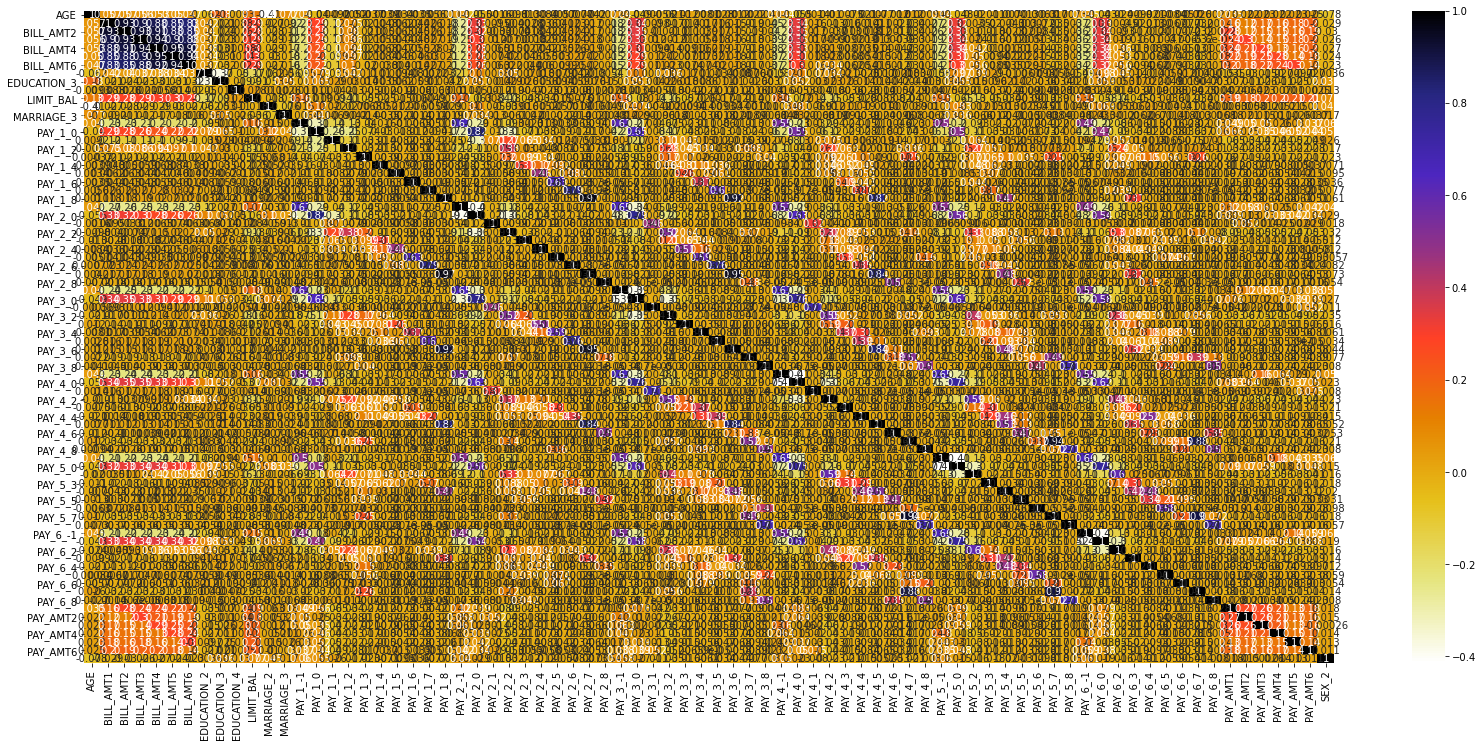

In [85]:
plt.figure(figsize = (28,12))
cor = x_train_sm.corr()
sns.heatmap(cor, annot = True, cmap = plt.cm.CMRmap_r)
plt.show()

In [86]:
cor

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,LIMIT_BAL,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_2
AGE,1.000000,0.057047,0.057430,0.055501,0.052704,0.050476,0.046750,-0.061616,0.184532,-0.009262,0.133474,-0.413971,0.077447,0.039505,-0.039670,0.009174,-0.005204,0.000374,-0.003929,0.003402,-0.003455,0.005562,0.001086,0.041687,-0.054681,-0.001647,-0.009777,-0.012577,0.008413,-0.005745,0.000768,0.004189,-0.007193,0.039746,-0.048981,-0.000557,-0.021403,0.011754,-0.008105,0.002823,0.001238,0.002176,0.004051,0.044326,-0.055203,0.001384,-0.010187,-0.007515,-0.021271,0.007749,-0.012187,0.012357,0.000940,0.040341,-0.048186,-0.020045,-0.010750,-0.007023,0.001306,-0.006290,0.016800,0.007265,0.044869,-0.043129,-0.023701,-0.009867,-0.020629,0.000841,-0.005663,0.025971,0.002718,0.035151,0.021546,0.023456,0.021772,0.022898,0.024602,-0.077925
BILL_AMT1,0.057047,1.000000,0.933794,0.897891,0.881036,0.852488,0.834423,0.042168,-0.020702,0.008840,0.291669,-0.026739,-0.009172,-0.230871,0.289524,-0.117604,0.075443,-0.021199,0.004800,0.006165,0.004411,0.026308,0.017708,-0.267144,0.328427,0.009461,-0.004019,-0.002845,0.003627,0.004057,0.023345,0.016823,-0.001849,-0.237965,0.341936,0.009759,-0.017355,-0.014443,0.001729,0.015993,0.014520,-0.019108,-0.004509,-0.227374,0.339104,0.016263,-0.012979,-0.016242,-0.001397,0.010956,-0.002127,-0.034490,-0.002668,-0.212139,0.322308,0.003544,-0.020097,-0.004339,-0.003036,0.007209,-0.034957,-0.003652,-0.211650,0.331822,0.000455,-0.019519,-0.012693,0.000672,-0.007748,-0.032369,-0.001358,0.157586,0.119694,0.165111,0.163727,0.178761,0.203470,-0.029228
BILL_AMT2,0.057430,0.933794,1.000000,0.926804,0.906126,0.876864,0.854788,0.040108,-0.023728,0.002609,0.284460,-0.028386,-0.011059,-0.225158,0.276940,-0.114883,0.080379,-0.021412,0.005040,0.006348,0.004515,0.026462,0.018319,-0.258737,0.319375,-0.003261,-0.000741,-0.001811,0.004225,0.004311,0.023765,0.017427,-0.001806,-0.248602,0.348151,0.010285,-0.001115,-0.010725,0.003887,0.017247,0.015191,-0.018762,-0.004040,-0.236253,0.347638,0.016686,-0.003724,-0.013133,0.000185,0.011870,-0.001075,-0.034188,-0.002630,-0.219876,0.329860,0.011312,-0.018007,-0.002309,-0.002108,0.008398,-0.034657,-0.003642,-0.217366,0.336990,0.009300,-0.017311,-0.011826,0.001702,-0.007177,-0.032283,-0.000220,0.276531,0.115402,0.151364,0.151934,0.162306,0.194120,-0.030043
BILL_AMT3,0.055501,0.897891,0.926804,1.000000,0.936066,0.899707,0.879918,0.037230,-0.023199,0.002106,0.288086,-0.029211,-0.011758,-0.214537,0.257263,-0.107243,0.086149,-0.021121,0.005890,0.004365,0.004756,0.026665,0.018751,-0.245303,0.298862,0.012431,0.007081,-0.000181,0.002865,0.004920,0.024070,0.017863,-0.001713,-0.231034,0.334540,0.011829,0.001231,-0.010580,0.005355,0.017652,0.015632,-0.018395,-0.003934,-0.243931,0.353446,0.016875,0.009892,-0.009171,0.001909,0.012707,-0.000392,-0.032847,-0.001928,-0.230489,0.336754,0.023800,-0.015560,-0.001205,-0.000501,0.012690,-0.033914,-0.003580,-0.222075,0.341194,0.018761,-0.015761,-0.010292,0.004689,-0.005995,-0.031740,-0.000056,0.241809,0.297901,0.138700,0.145569,0.183373,0.195767,-0.026211
BILL_AMT4,0.052704,0.881036,0.906126,0.936066,1.000000,0.949794,0.919412,0.037733,-0.031318,0.000579,0.298164,-0.028537,-0.016762,-0.204544,0.236923,-0.103095,0.093524,-0.022090,0.006779,0.004661,0.005508,0.028326,0.019991,-0.231160,0.276152,0.006491,0.014704,0.002743,0.004244,0.003452,0.025745,0.019100,-0.001594,-0.223136,0.312198,0.009433,0.013533,-0.009093

In [87]:
def correlation(dataset, threshold):
    col_corr = set()                                         # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:      # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]             # getting the name of column
                col_corr.add(colname)
    return col_corr

In [88]:
corr_features = correlation(x_train_sm, 0.8)
len(set(corr_features))

11

In [89]:
corr_features

{'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_2_0',
 'PAY_2_7',
 'PAY_3_6',
 'PAY_4_5',
 'PAY_5_7',
 'PAY_6_7'}

These features should be dropped but according to the domain, it is not dropped and considered as significant features.

# LOGISTIC REGRESSION (BASELINE MODEL)

In [90]:
lr = LogisticRegression()

In [91]:
lr.fit(x_train_sm, y_train_sm)

LogisticRegression()

In [92]:
preds_1 = lr.predict(x_test_fa_df)

In [93]:
lr.coef_

array([[ 1.56112068e-02, -1.55546909e-06, -5.36379161e-07,
        -3.26070567e-07, -3.70646835e-06,  5.71355231e-06,
         5.78794239e-06,  2.35976660e-04, -7.82037019e-05,
        -6.70167496e-06, -3.72117667e-06, -2.16608784e-04,
        -9.63200224e-06, -7.83908969e-05, -5.90163872e-04,
         3.86699038e-05,  2.38199233e-04,  2.36722040e-05,
         1.64004817e-06, -4.82788970e-07,  1.79835311e-07,
         1.70675873e-07, -1.32975053e-07,  2.23979259e-05,
        -4.00033840e-04, -4.17143084e-07,  2.76902137e-04,
         1.08517898e-05, -7.26892329e-07,  5.91667679e-07,
         2.41484862e-07, -1.88503142e-08, -1.26497350e-07,
        -6.36008053e-05, -2.96365798e-04, -1.16437815e-07,
         2.07122499e-04,  9.10686259e-06,  2.64706653e-07,
         3.01476341e-08, -1.94765176e-08,  2.99178017e-06,
         2.43917521e-07, -3.37135119e-05, -2.54338114e-04,
         6.26070155e-08,  1.65744402e-04,  6.71977681e-06,
         3.21900428e-06, -7.54083177e-08, -2.54025068e-0

In [94]:
lr.intercept_

array([0.0004314])

In [95]:
lr.score(x_train_sm, y_train_sm)

0.6232413835473367

In [96]:
lr.score(x_test_fa_df, y_test_fa_df)

0.566

# FEATURE IMPORTANCES

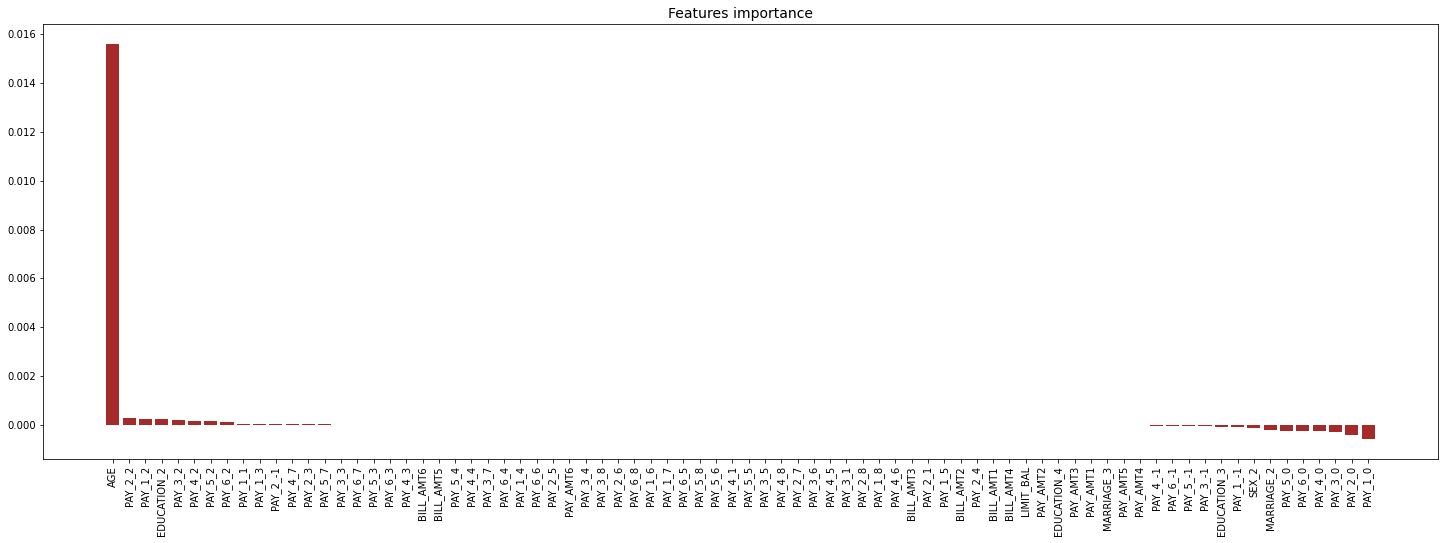

In [97]:
tmp = pd.DataFrame(data = {'Feature' : x_train_sm.columns, 'Feature Importance' : lr.coef_[0]})
tmp = tmp.sort_values(by = 'Feature Importance', ascending = False)

plt.figure(figsize = (25,8))
plt.title('Features importance',fontsize = 14)

plt.bar(x = tmp['Feature'], height = tmp['Feature Importance'], color = 'brown')
plt.xticks(rotation = 'vertical')

plt.show() 

The important features using Logistic Regression are AGE, PAY_2_2, EDUCATION_2, PAY_1_2, PAY_3_2 and PAY_4_2.

# CLASSIFICATION REPORT

In [98]:
lr_cv_score1 = cross_val_score(lr, x_train_sm, y_train_sm, cv = 10, scoring = 'precision')
lr_cv_score2 = cross_val_score(lr, x_train_sm, y_train_sm, cv = 10, scoring = 'recall')
lr_cv_score3 = cross_val_score(lr, x_train_sm, y_train_sm, cv = 10, scoring = 'f1')
lr_cv_score4 = cross_val_score(lr, x_train_sm, y_train_sm, cv = 10, scoring = 'accuracy')
lr_cv_score5 = cross_val_score(lr, x_train_sm, y_train_sm, cv = 10, scoring = 'roc_auc')

In [99]:
s1 = precision_score(y_test_fa_df, preds_1)
s2 = recall_score(y_test_fa_df, preds_1)
s3 = f1_score(y_test_fa_df, preds_1)
s4 = accuracy_score(y_test_fa_df, preds_1)
s5 = roc_auc_score(y_test_fa_df, preds_1)

In [100]:
print('Mean Precision Score - Logistic Regression:',lr_cv_score1.mean())
print('Test Precision Score - Logistic Regression:', s1)
print()
print('Mean Recall Score - Logistic Regression:',lr_cv_score2.mean())
print('Test Recall Score - Logistic Regression:', s2)
print()
print('Mean F1 Score - Logistic Regression:',lr_cv_score3.mean())
print('Test F1 Score - Logistic Regression:', s3)
print()
print('Mean Accuracy Score - Logistic Regression:',lr_cv_score4.mean())
print('Test Accuracy Score - Logistic Regression:', s4)
print()
print('Mean roc_auc_score - Logistic Regression:',lr_cv_score5.mean())
print('Test roc_auc_score - Logistic Regression:', s5)

Mean Precision Score - Logistic Regression: 0.6108462997542772
Test Precision Score - Logistic Regression: 0.2837925797353005

Mean Recall Score - Logistic Regression: 0.6933773061769373
Test Recall Score - Logistic Regression: 0.683742812336644

Mean F1 Score - Logistic Regression: 0.6465071635958265
Test F1 Score - Logistic Regression: 0.40110395584176634

Mean Accuracy Score - Logistic Regression: 0.6250858158116224
Test Accuracy Score - Logistic Regression: 0.566

Mean roc_auc_score - Logistic Regression: 0.6731054291188228
Test roc_auc_score - Logistic Regression: 0.608980196911937


# CONFUSION MATRIX

In [101]:
print(confusion_matrix(y_test_fa_df, preds_1))

[[3786 3301]
 [ 605 1308]]


In [102]:
y_test_1d = y_test_fa_df.values.flatten()

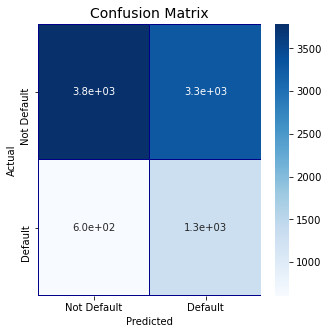

In [103]:
cm = pd.crosstab(y_test_1d, preds_1, rownames = ['Actual'], colnames = ['Predicted'])

fig, (ax1) = plt.subplots(ncols = 1, figsize = (5,5))

sns.heatmap(cm, 
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True, ax = ax1,
            linewidths = .2, linecolor = "Darkblue", cmap = "Blues")

plt.title('Confusion Matrix', fontsize = 14)
plt.show()

# KNN ALGORITHM

In [104]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    knn.fit(x_train_sm,y_train_sm)
    pred_i = knn.predict(x_test_fa_df)
    error_rate.append(np.mean(pred_i != y_test))

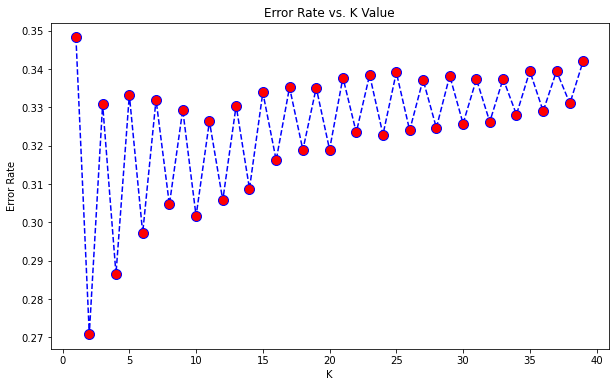

In [105]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o', markerfacecolor = 'red', markersize = 10)

plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [106]:
print("Minimum error:",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Minimum error: 0.2708888888888889 at K = 1


In [107]:
knn = KNeighborsClassifier(n_neighbors = 1,)

In [108]:
knn.fit(x_train_sm, y_train_sm)

KNeighborsClassifier(n_neighbors=1)

In [109]:
preds_2 = knn.predict(x_test_fa_df)

In [110]:
knn.score(x_train_sm, y_train_sm)

0.9987712723474842

In [111]:
knn.score(x_test_fa_df, y_test_fa_df)

0.6517777777777778

# CLASSIFICATION REPORT

In [112]:
knn_cv_score1 = cross_val_score(knn, x_train_sm, y_train_sm, cv = 10, scoring = 'precision')
knn_cv_score2 = cross_val_score(knn, x_train_sm, y_train_sm, cv = 10, scoring = 'recall')
knn_cv_score3 = cross_val_score(knn, x_train_sm, y_train_sm, cv = 10, scoring = 'f1')
knn_cv_score4 = cross_val_score(knn, x_train_sm, y_train_sm, cv = 10, scoring = 'accuracy')
knn_cv_score5 = cross_val_score(knn, x_train_sm, y_train_sm, cv = 10, scoring = 'roc_auc')

In [113]:
s11 = precision_score(y_test_fa_df, preds_2)
s12 = recall_score(y_test_fa_df, preds_2)
s13 = f1_score(y_test_fa_df, preds_2)
s14 = accuracy_score(y_test_fa_df, preds_2)
s15 = roc_auc_score(y_test_fa_df, preds_2)

In [114]:
print('Mean Precision Score - KNN Algorithm:',knn_cv_score1.mean())
print('Test Precision Score - KNN Algorithm:', s11)
print()
print('Mean Recall Score - KNN Algorithm:',knn_cv_score2.mean())
print('Test Recall Score - KNN Algorithm:', s12)
print()
print('Mean F1 Score - KNN Algorithm:',knn_cv_score3.mean())
print('Test F1 Score - KNN Algorithm:', s13)
print()
print('Mean Accuracy Score - KNN Algorithm:',knn_cv_score4.mean())
print('Test Accuracy Score - KNN Algorithm:', s14)
print()
print('Mean roc_auc_score - KNN Algorithm:',knn_cv_score5.mean())
print('Test roc_auc_score - KNN Algorithm:', s15)

Mean Precision Score - KNN Algorithm: 0.7180226792159099
Test Precision Score - KNN Algorithm: 0.26918714555765594

Mean Recall Score - KNN Algorithm: 0.7433327569621362
Test Recall Score - KNN Algorithm: 0.3721902770517512

Mean F1 Score - KNN Algorithm: 0.7278570564170178
Test F1 Score - KNN Algorithm: 0.31241772707327775

Mean Accuracy Score - KNN Algorithm: 0.7284272731046925
Test Accuracy Score - KNN Algorithm: 0.6517777777777778

Mean roc_auc_score - KNN Algorithm: 0.7284274768985894
Test roc_auc_score - KNN Algorithm: 0.5497186745778017


# CONFUSION MATRIX

In [115]:
print(confusion_matrix(y_test_fa_df, preds_2))

[[5154 1933]
 [1201  712]]


In [116]:
y_test_1d = y_test_fa_df.values.flatten()

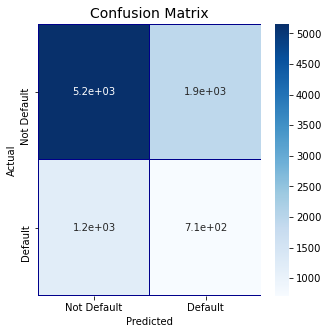

In [117]:
cm = pd.crosstab(y_test_1d, preds_2, rownames = ['Actual'], colnames = ['Predicted'])

fig, (ax1) = plt.subplots(ncols = 1, figsize = (5,5))

sns.heatmap(cm, 
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True, ax = ax1,
            linewidths = .2, linecolor = "Darkblue", cmap = "Blues")

plt.title('Confusion Matrix', fontsize = 14)
plt.show()

# XGBOOST CLASSIFIER

In [118]:
xgb = XGBClassifier()

In [119]:
xgb.fit(x_train_sm, y_train_sm)

[16:38:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
preds_3 = xgb.predict(x_test_fa_df)

In [121]:
xgb.score(x_train_sm, y_train_sm)

0.9018860969466118

In [122]:
xgb.score(x_test_fa_df, y_test_fa_df)

0.788

In [123]:
xgb.feature_importances_

array([0.00481924, 0.00943135, 0.00670695, 0.00654805, 0.00685553,
       0.00681303, 0.00633037, 0.00664986, 0.01992265, 0.00879735,
       0.01500789, 0.02418807, 0.01113378, 0.17866534, 0.24768499,
       0.0547968 , 0.01796976, 0.00769089, 0.01224447, 0.        ,
       0.        , 0.        , 0.00476381, 0.02038026, 0.00782309,
       0.        , 0.01103644, 0.00435792, 0.01038678, 0.        ,
       0.        , 0.        , 0.        , 0.03543752, 0.00952989,
       0.        , 0.00846534, 0.00334834, 0.00491747, 0.00162535,
       0.00145367, 0.00168284, 0.        , 0.01819806, 0.01552474,
       0.        , 0.0111942 , 0.00667499, 0.        , 0.00438904,
       0.        , 0.        , 0.        , 0.01457545, 0.00716459,
       0.00945603, 0.00508389, 0.00189344, 0.00166087, 0.        ,
       0.        , 0.        , 0.0154144 , 0.01336002, 0.01936339,
       0.01932166, 0.        , 0.        , 0.        , 0.00070154,
       0.        , 0.00729789, 0.00633709, 0.00591476, 0.00639

# FEATURE IMPORTANCES

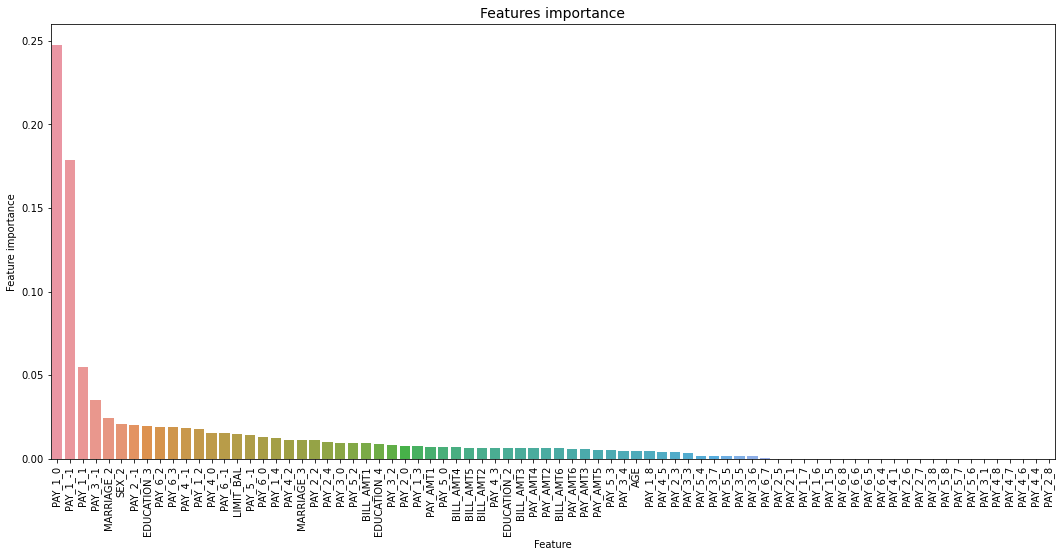

In [124]:
tmp = pd.DataFrame({'Feature' : x_train_sm.columns, 'Feature importance' : xgb.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)

plt.figure(figsize = (18,8))
plt.title('Features importance',fontsize = 14)

s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(),rotation = 90)

plt.show() 

The important features using XBGClassifer are PAY_1_0, PAY_1_-1, PAY_1_1, PAY_3_-1, MARRIAGE_2 and SEX_2. 

# CLASSIFICATION REPORT

In [125]:
xgb_cv_score1 = cross_val_score(xgb, x_train_sm, y_train_sm, cv = 10, scoring = 'precision')
xgb_cv_score2 = cross_val_score(xgb, x_train_sm, y_train_sm, cv = 10, scoring = 'recall')
xgb_cv_score3 = cross_val_score(xgb, x_train_sm, y_train_sm, cv = 10, scoring = 'f1')
xgb_cv_score4 = cross_val_score(xgb, x_train_sm, y_train_sm, cv = 10, scoring = 'accuracy')
xgb_cv_score5 = cross_val_score(xgb, x_train_sm, y_train_sm, cv = 10, scoring = 'roc_auc')

[16:39:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:11] WARNING: /Users/runner/miniforge3/cond

[16:40:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:59] WARNING: /Users/runner/miniforge3/cond

In [126]:
s21 = precision_score(y_test_fa_df, preds_3)
s22 = recall_score(y_test_fa_df, preds_3)
s23 = f1_score(y_test_fa_df, preds_3)
s24 = accuracy_score(y_test_fa_df, preds_3)
s25 = roc_auc_score(y_test_fa_df, preds_3)

In [127]:
print('Mean Precision Score - XGBClassifier:',xgb_cv_score1.mean())
print('Test Precision Score - XGBClassifier:', s21)
print()
print('Mean Recall Score - XGBClassifier:',xgb_cv_score2.mean())
print('Test Recall Score - XGBClassifier:', s22)
print()
print('Mean F1 Score - XGBClassifier:',xgb_cv_score3.mean())
print('Test F1 Score - XGBClassifier:', s23)
print()
print('Mean Accuracy Score - XGBClassifier:',xgb_cv_score4.mean())
print('Test Accuracy Score - XGBClassifier:', s24)
print()
print('Mean roc_auc_score - XGBClassifier:',xgb_cv_score5.mean())
print('Test roc_auc_score - XGBClassifier:', s25)

Mean Precision Score - XGBClassifier: 0.8458314097596776
Test Precision Score - XGBClassifier: 0.5013535462912831

Mean Recall Score - XGBClassifier: 0.8031853443654304
Test Recall Score - XGBClassifier: 0.48405645582854157

Mean F1 Score - XGBClassifier: 0.8101095915050779
Test F1 Score - XGBClassifier: 0.4925531914893618

Mean Accuracy Score - XGBClassifier: 0.8336128220805639
Test Accuracy Score - XGBClassifier: 0.788

Mean roc_auc_score - XGBClassifier: 0.9108710416372438
Test roc_auc_score - XGBClassifier: 0.6770500989457369


# CONFUSION MATRIX

In [128]:
print(confusion_matrix(y_test_fa_df, preds_3))

[[6166  921]
 [ 987  926]]


In [129]:
y_test_1d = y_test_fa_df.values.flatten()

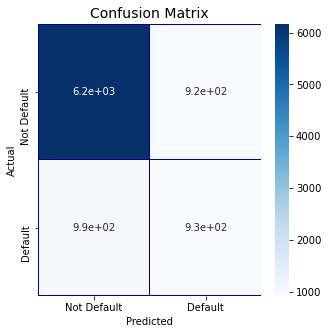

In [130]:
cm = pd.crosstab(y_test_1d, preds_3, rownames = ['Actual'], colnames = ['Predicted'])

fig, (ax1) = plt.subplots(ncols = 1, figsize = (5,5))

sns.heatmap(cm, 
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True, ax = ax1,
            linewidths = .2, linecolor = "Darkblue", cmap = "Blues")

plt.title('Confusion Matrix', fontsize = 14)
plt.show()

# RANDOM FOREST CLASSIFIER

In [131]:
rfc = RandomForestClassifier(n_jobs = 4, 
                             random_state = 3,
                             criterion = 'gini',
                             n_estimators = 100,
                             verbose = False)

In [132]:
rfc.fit(x_train_sm, y_train_sm)

RandomForestClassifier(n_jobs=4, random_state=3, verbose=False)

In [133]:
preds_4 = rfc.predict(x_test_fa_df)

In [134]:
rfc.feature_importances_

array([5.33213106e-02, 5.28592690e-02, 4.76641964e-02, 4.50385086e-02,
       4.71887049e-02, 4.50977900e-02, 4.26730077e-02, 9.95510995e-03,
       8.86534890e-03, 5.09491709e-04, 6.79828944e-02, 2.41595945e-02,
       1.34897108e-03, 2.01193603e-02, 6.78185225e-02, 1.49677553e-02,
       1.53994468e-02, 7.50014850e-04, 2.70755480e-04, 1.51983881e-04,
       2.79349308e-05, 1.60298269e-05, 8.61524285e-05, 1.20877318e-02,
       2.55096091e-02, 1.31471699e-04, 1.01865757e-02, 7.81485929e-04,
       6.42562454e-04, 7.17409717e-05, 2.14449079e-05, 7.64072310e-05,
       1.00890613e-05, 1.51804831e-02, 1.38024166e-02, 2.18291450e-05,
       4.80660163e-03, 6.77203526e-04, 3.14228397e-04, 5.14372364e-05,
       7.04998892e-05, 4.33590079e-05, 1.77594978e-10, 7.84164846e-03,
       9.92975589e-03, 5.14930198e-06, 3.83047423e-03, 5.20279324e-04,
       2.36229510e-04, 1.24052360e-04, 4.45898855e-05, 1.11000600e-04,
       1.37958227e-05, 9.43427132e-03, 1.08555951e-02, 3.32529445e-03,
      

In [135]:
rfc.score(x_train_sm, y_train_sm)

0.9991706088345518

In [136]:
rfc.score(x_test_fa_df, y_test_fa_df)

0.8027777777777778

# FEATURE IMPORTANCES

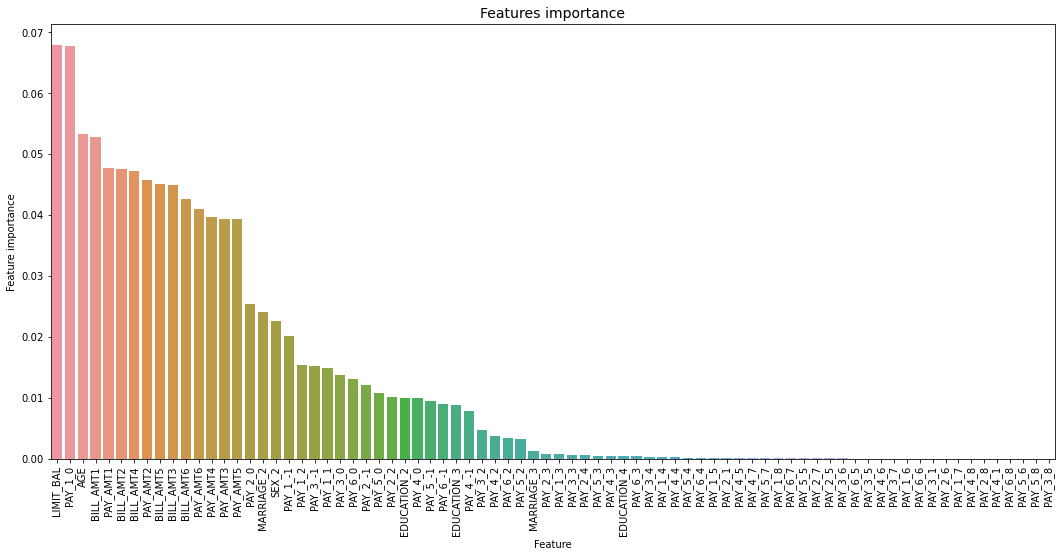

In [137]:
tmp = pd.DataFrame({'Feature' : x_train_sm.columns, 'Feature importance' : rfc.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)

plt.figure(figsize = (18,8))
plt.title('Features importance',fontsize = 14)

s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(),rotation = 90)

plt.show() 

The important features using Random Forest Classifier are PAY_1_0, LIMIT_BAL, BILL_AMT1, AGE, BILL_AMT2 and PAY_AMT1.

# CLASSIFICATION REPORT

In [138]:
rfc_cv_score1 = cross_val_score(rfc, x_train_sm, y_train_sm, cv = 10, scoring = 'precision')
rfc_cv_score2 = cross_val_score(rfc, x_train_sm, y_train_sm, cv = 10, scoring = 'recall')
rfc_cv_score3 = cross_val_score(rfc, x_train_sm, y_train_sm, cv = 10, scoring = 'f1')
rfc_cv_score4 = cross_val_score(rfc, x_train_sm, y_train_sm, cv = 10, scoring = 'accuracy')
rfc_cv_score5 = cross_val_score(rfc, x_train_sm, y_train_sm, cv = 10, scoring = 'roc_auc')

In [139]:
s31 = precision_score(y_test_fa_df, preds_4)
s32 = recall_score(y_test_fa_df, preds_4)
s33 = f1_score(y_test_fa_df, preds_4)
s34 = accuracy_score(y_test_fa_df, preds_4)
s35 = roc_auc_score(y_test_fa_df, preds_4)

In [140]:
print('Mean Precision Score - Random Forest Classifier:',rfc_cv_score1.mean())
print('Test Precision Score - Random Forest Classifier:', s31)
print()
print('Mean Recall Score - Random Forest Classifier:',rfc_cv_score2.mean())
print('Test Recall Score - Random Forest Classifier:', s32)
print()
print('Mean F1 Score - Random Forest Classifier:',rfc_cv_score3.mean())
print('Test F1 Score - Random Forest Classifier:', s33)
print()
print('Mean Accuracy Score - Random Forest Classifier:',rfc_cv_score4.mean())
print('Test Accuracy Score - Random Forest Classifier:', s34)
print()
print('Mean roc_auc_score - Random Forest Classifier:',rfc_cv_score5.mean())
print('Test roc_auc_score - Random ForesClassifier:', s35)

Mean Precision Score - Random Forest Classifier: 0.8707257050714545
Test Precision Score - Random Forest Classifier: 0.5425925925925926

Mean Recall Score - Random Forest Classifier: 0.8130105226755504
Test Recall Score - Random Forest Classifier: 0.4594877156299007

Mean F1 Score - Random Forest Classifier: 0.8301486063217066
Test F1 Score - Random Forest Classifier: 0.497594112652137

Mean Accuracy Score - Random Forest Classifier: 0.8489083983438823
Test Accuracy Score - Random Forest Classifier: 0.8027777777777778

Mean roc_auc_score - Random Forest Classifier: 0.9200645637537852
Test roc_auc_score - Random ForesClassifier: 0.6774650374396152


# CONFUSION MATRIX

In [141]:
print(confusion_matrix(y_test_fa_df, preds_4))

[[6346  741]
 [1034  879]]


In [142]:
y_test_1d = y_test_fa_df.values.flatten()

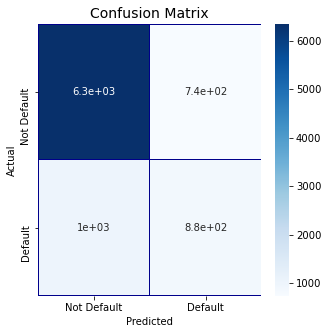

In [143]:
cm = pd.crosstab(y_test_1d, preds_4, rownames = ['Actual'], colnames = ['Predicted'])

fig, (ax1) = plt.subplots(ncols = 1, figsize = (5,5))

sns.heatmap(cm, 
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True, ax = ax1,
            linewidths = .2, linecolor = "Darkblue", cmap = "Blues")

plt.title('Confusion Matrix', fontsize = 14)
plt.show()

# DECISION TREE CLASSIFIER 

In [144]:
dtc = DecisionTreeClassifier(criterion = 'gini',
                             random_state = 3,
                             max_depth = 7,
                             min_samples_leaf = 5)

In [145]:
dtc.fit(x_train_sm, y_train_sm)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, random_state=3)

In [146]:
preds_5 = dtc.predict(x_test_fa_df)

In [147]:
dtc.score(x_train_sm, y_train_sm)

0.7866928795232536

In [148]:
dtc.score(x_test_fa_df, y_test_fa_df)

0.7523333333333333

In [149]:
dtc.feature_importances_

array([0.00850727, 0.06402815, 0.01317356, 0.00491146, 0.00549471,
       0.00759145, 0.0012305 , 0.00404869, 0.00719804, 0.        ,
       0.09777938, 0.02797027, 0.00172575, 0.20625855, 0.3477663 ,
       0.07809507, 0.00795226, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01680839, 0.00284438,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00337328, 0.00093369,
       0.        , 0.00118673, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01464132, 0.00635802,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00100934,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00249403, 0.00343074, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01883671, 0.00479839, 0.00077506, 0.01171

# FEATURE IMPORTANCES

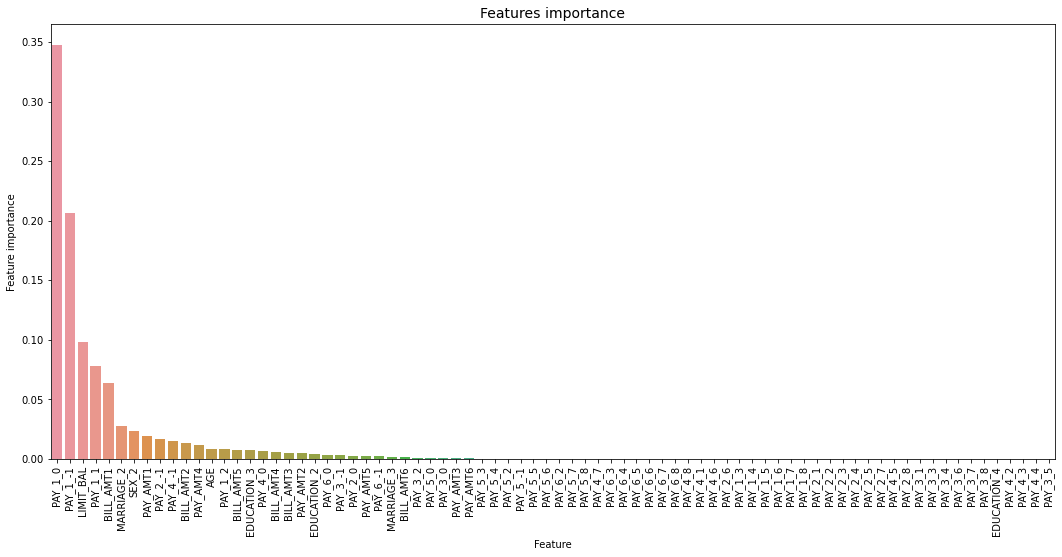

In [150]:
tmp = pd.DataFrame({'Feature' : x_train_sm.columns, 'Feature importance' : dtc.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)

plt.figure(figsize = (18,8))
plt.title('Features importance',fontsize = 14)

s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(),rotation = 90)

plt.show() 

The significant features using Decision Tree Classifier are PAY_1_0, PAY_1_-1, LIMIT_BAL, PAY_1_1, BILL_AMT1 and MARRIAGE_2.

# CLASSIFICATION REPORT

In [151]:
dtc_cv_score1 = cross_val_score(dtc, x_train_sm, y_train_sm, cv = 10, scoring = 'precision')
dtc_cv_score2 = cross_val_score(dtc, x_train_sm, y_train_sm, cv = 10, scoring = 'recall')
dtc_cv_score3 = cross_val_score(dtc, x_train_sm, y_train_sm, cv = 10, scoring = 'f1')
dtc_cv_score4 = cross_val_score(dtc, x_train_sm, y_train_sm, cv = 10, scoring = 'accuracy')
dtc_cv_score5 = cross_val_score(dtc, x_train_sm, y_train_sm, cv = 10, scoring = 'roc_auc')

In [152]:
s41 = precision_score(y_test_fa_df, preds_5)
s42 = recall_score(y_test_fa_df, preds_5)
s43 = f1_score(y_test_fa_df, preds_5)
s44 = accuracy_score(y_test_fa_df, preds_5)
s45 = roc_auc_score(y_test_fa_df, preds_5)

In [153]:
print('Mean Precision Score - Decision Tree Classifier:',dtc_cv_score1.mean())
print('Test Precision Score - Decision Tree Classifier:', s41)
print()
print('Mean Recall Score - Decision Tree Classifier:',dtc_cv_score2.mean())
print('Test Recall Score - Decision Tree Classifier:', s42)
print()
print('Mean F1 Score - Decision Tree Classifier:',dtc_cv_score3.mean())
print('Test F1 Score - Decision Tree Classifier:', s43)
print()
print('Mean Accuracy Score - Decision Tree Classifier:',dtc_cv_score4.mean())
print('Test Accuracy Score - Decision Tree Classifier:', s44)
print()
print('Mean roc_auc_score - Decision Tree Classifier:',dtc_cv_score5.mean())
print('Test roc_auc_score - Decision Tree Classifier:', s45)

Mean Precision Score - Decision Tree Classifier: 0.7714891425179631
Test Precision Score - Decision Tree Classifier: 0.43253629376601194

Mean Recall Score - Decision Tree Classifier: 0.7537781887044334
Test Recall Score - Decision Tree Classifier: 0.5295347621536853

Mean F1 Score - Decision Tree Classifier: 0.7590720403242013
Test F1 Score - Decision Tree Classifier: 0.47614571092831964

Mean Accuracy Score - Decision Tree Classifier: 0.7682395917073336
Test Accuracy Score - Decision Tree Classifier: 0.7523333333333333

Mean roc_auc_score - Decision Tree Classifier: 0.8442457883933336
Test roc_auc_score - Decision Tree Classifier: 0.6710041526303915


# CONFUSION MATRIX

In [154]:
print(confusion_matrix(y_test_fa_df, preds_5))

[[5758 1329]
 [ 900 1013]]


In [155]:
y_test_1d = y_test_fa_df.values.flatten()

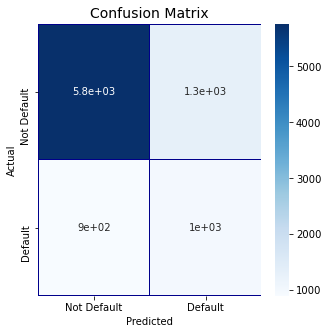

In [156]:
cm = pd.crosstab(y_test_1d, preds_5, rownames = ['Actual'], colnames = ['Predicted'])

fig, (ax1) = plt.subplots(ncols = 1, figsize = (5,5))

sns.heatmap(cm, 
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True, ax = ax1,
            linewidths = .2, linecolor = "Darkblue", cmap = "Blues")

plt.title('Confusion Matrix', fontsize = 14)
plt.show()

# GAUSSIAN NAIVE BAYES ALGORITHM

In [157]:
gnb = GaussianNB()

In [158]:
gnb.fit(x_train_sm, y_train_sm)

GaussianNB()

In [159]:
preds_6 = gnb.predict(x_test_fa_df)

In [160]:
gnb.score(x_train_sm, y_train_sm)

0.5454629231430853

In [161]:
gnb.score(x_test_fa_df, y_test_fa_df)

0.325

# CLASSIFICATION REPORT

In [162]:
gnb_cv_score1 = cross_val_score(gnb, x_train_sm, y_train_sm, cv = 10, scoring = 'precision')
gnb_cv_score2 = cross_val_score(gnb, x_train_sm, y_train_sm, cv = 10, scoring = 'recall')
gnb_cv_score3 = cross_val_score(gnb, x_train_sm, y_train_sm, cv = 10, scoring = 'f1')
gnb_cv_score4 = cross_val_score(gnb, x_train_sm, y_train_sm, cv = 10, scoring = 'accuracy')
gnb_cv_score5 = cross_val_score(gnb, x_train_sm, y_train_sm, cv = 10, scoring = 'roc_auc')

In [163]:
s51 = precision_score(y_test_fa_df, preds_6)
s52 = recall_score(y_test_fa_df, preds_6)
s53 = f1_score(y_test_fa_df, preds_6)
s54 = accuracy_score(y_test_fa_df, preds_6)
s55 = roc_auc_score(y_test_fa_df, preds_6)

In [164]:
print('Mean Precision Score - Gaussian NB Classifier:',gnb_cv_score1.mean())
print('Test Precision Score - Gaussian NB Classifier:', s51)
print()
print('Mean Recall Score - Gaussian NB Classifier:',gnb_cv_score2.mean())
print('Test Recall Score - Gaussian NB Classifier:', s52)
print()
print('Mean F1 Score - Gaussian NB Classifier:',gnb_cv_score3.mean())
print('Test F1 Score - Gaussian NB Classifier:', s53)
print()
print('Mean Accuracy Score - Gaussian NB Classifier:',gnb_cv_score4.mean())
print('Test Accuracy Score - Gaussian NB Classifier:', s54)
print()
print('Mean roc_auc_score - Gaussian NB Classifier:',gnb_cv_score5.mean())
print('Test roc_auc_score - Gaussian NB Classifier:', s55)

Mean Precision Score - Gaussian NB Classifier: 0.5258951160597019
Test Precision Score - Gaussian NB Classifier: 0.22917751171264966

Mean Recall Score - Gaussian NB Classifier: 0.9250485133398471
Test Recall Score - Gaussian NB Classifier: 0.9205436487192891

Mean F1 Score - Gaussian NB Classifier: 0.670557667796922
Test F1 Score - Gaussian NB Classifier: 0.3669896842763363

Mean Accuracy Score - Gaussian NB Classifier: 0.5455549296678329
Test Accuracy Score - Gaussian NB Classifier: 0.325

Mean roc_auc_score - Gaussian NB Classifier: 0.6651246026561789
Test roc_auc_score - Gaussian NB Classifier: 0.5423940199289969


# CONFUSION MATRIX

In [165]:
print(confusion_matrix(y_test_fa_df, preds_6))

[[1164 5923]
 [ 152 1761]]


In [166]:
y_test_1d = y_test_fa_df.values.flatten()

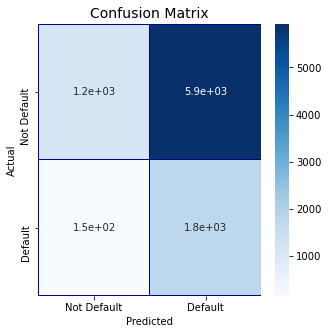

In [167]:
cm = pd.crosstab(y_test_1d, preds_6, rownames = ['Actual'], colnames = ['Predicted'])

fig, (ax1) = plt.subplots(ncols = 1, figsize = (5,5))

sns.heatmap(cm, 
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True, ax = ax1,
            linewidths = .2, linecolor = "Darkblue", cmap = "Blues")

plt.title('Confusion Matrix', fontsize = 14)
plt.show()

# ADA BOOST CLASSIFIER

In [168]:
abc = AdaBoostClassifier(random_state = 3,
                         algorithm = 'SAMME.R',
                         learning_rate = 0.8,
                         n_estimators = 100)

In [169]:
abc.fit(x_train_sm, y_train_sm)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=3)

In [170]:
preds_7 = abc.predict(x_test_fa_df)

In [171]:
abc.feature_importances_

array([0.02, 0.07, 0.05, 0.05, 0.04, 0.04, 0.04, 0.02, 0.02, 0.01, 0.05,
       0.02, 0.01, 0.02, 0.04, 0.03, 0.01, 0.  , 0.01, 0.  , 0.  , 0.  ,
       0.01, 0.02, 0.  , 0.  , 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.01, 0.02, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.05, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.04, 0.04, 0.05, 0.02, 0.04,
       0.01])

In [172]:
abc.score(x_train_sm, y_train_sm)

0.7866621613319408

In [173]:
abc.score(x_test_fa_df, y_test_fa_df)

0.7511111111111111

# FEATURE IMPORTANCES

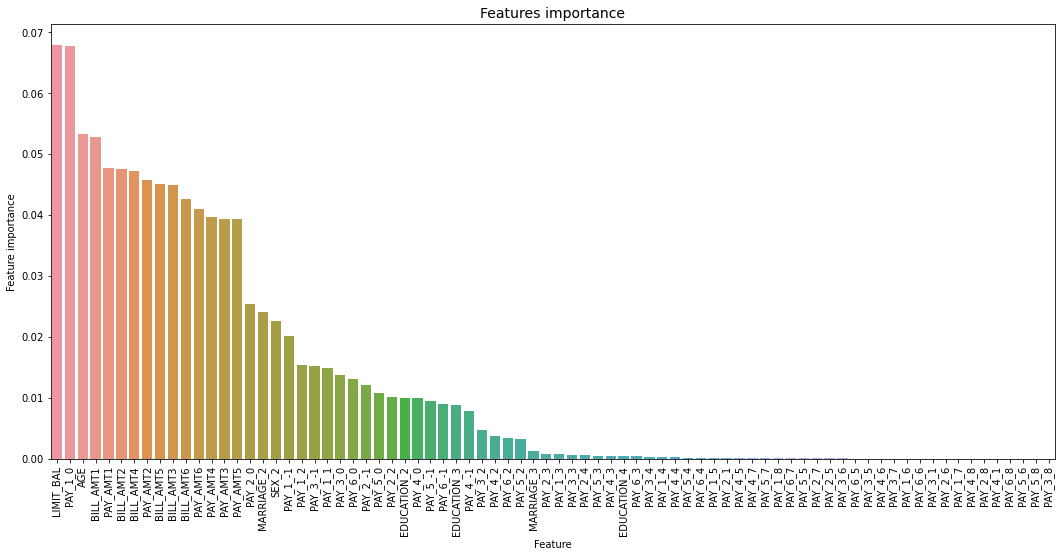

In [174]:
tmp = pd.DataFrame({'Feature' : x_train_sm.columns, 'Feature importance' : rfc.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)

plt.figure(figsize = (18,8))
plt.title('Features importance',fontsize = 14)

s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(),rotation = 90)

plt.show() 

The important features are PAY_1_0, LIMIT_BAL, BILL_AMT1, AGE, BILL_AMT2 and PAY_AMT1.

# CLASSIFICATION REPORT

In [175]:
abc_cv_score1 = cross_val_score(abc, x_train_sm, y_train_sm, cv = 10, scoring = 'precision')
abc_cv_score2 = cross_val_score(abc, x_train_sm, y_train_sm, cv = 10, scoring = 'recall')
abc_cv_score3 = cross_val_score(abc, x_train_sm, y_train_sm, cv = 10, scoring = 'f1')
abc_cv_score4 = cross_val_score(abc, x_train_sm, y_train_sm, cv = 10, scoring = 'accuracy')
abc_cv_score5 = cross_val_score(abc, x_train_sm, y_train_sm, cv = 10, scoring = 'roc_auc')

In [176]:
s61 = precision_score(y_test_fa_df, preds_7)
s62 = recall_score(y_test_fa_df, preds_7)
s63 = f1_score(y_test_fa_df, preds_7)
s64 = accuracy_score(y_test_fa_df, preds_7)
s65 = roc_auc_score(y_test_fa_df, preds_7)

In [177]:
print('Mean Precision Score - AdaBoost Classifier:',abc_cv_score1.mean())
print('Test Precision Score - AdaBoost Classifier:', s61)
print()
print('Mean Recall Score - AdaBoost Classifier:',abc_cv_score2.mean())
print('Test Recall Score - AdaBoost Classifier:', s62)
print()
print('Mean F1 Score - AdaBoost Classifier:',abc_cv_score3.mean())
print('Test F1 Score - AdaBoost Classifier:', s63)
print()
print('Mean Accuracy Score - AdaBoost Classifier:',abc_cv_score4.mean())
print('Test Accuracy Score - AdaBoost Classifier:', s64)
print()
print('Mean roc_auc_score - AdaBoost Classifier:',abc_cv_score5.mean())
print('Test roc_auc_score - AdaBoost Classifier:', s65)

Mean Precision Score - AdaBoost Classifier: 0.7875528307488369
Test Precision Score - AdaBoost Classifier: 0.4326328800988875

Mean Recall Score - AdaBoost Classifier: 0.7574064202214171
Test Recall Score - AdaBoost Classifier: 0.5488761108207004

Mean F1 Score - AdaBoost Classifier: 0.7657270158251297
Test F1 Score - AdaBoost Classifier: 0.48387096774193544

Mean Accuracy Score - AdaBoost Classifier: 0.7804356461614527
Test Accuracy Score - AdaBoost Classifier: 0.7511111111111111

Mean roc_auc_score - AdaBoost Classifier: 0.861080188297229
Test roc_auc_score - AdaBoost Classifier: 0.6772883446723793


# CONFUSION MATRIX

In [178]:
print(confusion_matrix(y_test_fa_df, preds_7))

[[5710 1377]
 [ 863 1050]]


In [179]:
y_test_1d = y_test_fa_df.values.flatten()

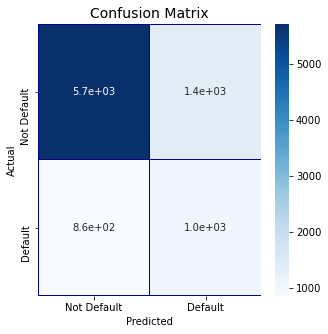

In [180]:
cm = pd.crosstab(y_test_1d, preds_7, rownames = ['Actual'], colnames = ['Predicted'])

fig, (ax1) = plt.subplots(ncols = 1, figsize = (5,5))

sns.heatmap(cm, 
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True, ax = ax1,
            linewidths = .2, linecolor = "Darkblue", cmap = "Blues")

plt.title('Confusion Matrix', fontsize = 14)
plt.show()

# CONCLUSION

In [181]:
pd.DataFrame({'Precision' : [lr_cv_score1.mean(), s1, knn_cv_score1.mean(), s11, xgb_cv_score1.mean(), s21, rfc_cv_score1.mean(), s31, dtc_cv_score1.mean(), s41, gnb_cv_score1.mean(), s51, abc_cv_score1.mean(), s61],
              'Recall' : [lr_cv_score2.mean(), s2, knn_cv_score2.mean(), s12, xgb_cv_score2.mean(), s22, rfc_cv_score2.mean(), s32, dtc_cv_score2.mean(), s42, gnb_cv_score2.mean(), s52, abc_cv_score2.mean(), s62],
              'F1 Score' : [lr_cv_score3.mean(), s3, knn_cv_score3.mean(), s13, xgb_cv_score3.mean(), s23, rfc_cv_score3.mean(), s33, dtc_cv_score3.mean(), s43, gnb_cv_score3.mean(), s53, abc_cv_score3.mean(), s63],
              'Accuracy' : [lr_cv_score4.mean(), s4, knn_cv_score4.mean(), s14, xgb_cv_score4.mean(), s24, rfc_cv_score4.mean(), s34, dtc_cv_score4.mean(), s44, gnb_cv_score4.mean(), s54, abc_cv_score4.mean(), s64],
              'Roc_auc' : [lr_cv_score5.mean(), s5, knn_cv_score5.mean(), s15, xgb_cv_score5.mean(), s25, rfc_cv_score5.mean(), s35, dtc_cv_score5.mean(), s45, gnb_cv_score5.mean(), s55, abc_cv_score5.mean(), s65]},
                      
              index = ['Logistic Regression(Train)', 'Logistic Regression(Test)', 'KNN(Train)', 'KNN(Test)', 'XGBClassifier(Train)', 'XGBClassifier(Test)', 'Random Forest(Train)', 'Random Forest(Test)',
                       'Decision Tree(Train)', 'Decision Tree(Test)', 'GaussianNB(Train)', 'GaussianNB(Test)', 'AdaBoost(Train)', 'AdaBoost(Test)'])

,Precision,Recall,F1 Score,Accuracy,Roc_auc
Logistic Regression(Train),0.610846,0.693377,0.646507,0.625086,0.673105
Logistic Regression(Test),0.283793,0.683743,0.401104,0.566000,0.608980
KNN(Train),0.718023,0.743333,0.727857,0.728427,0.728427
KNN(Test),0.269187,0.372190,0.312418,0.651778,0.549719
XGBClassifier(Train),0.845831,0.803185,0.810110,0.833613,0.910871
XGBClassifier(Test),0.501354,0.484056,0.492553,0.788000,0.677050
Random Forest(Train),0.870726,0.813011,0.830149,0.848908,0.920065
Random Forest(Test),0.542593,0.459488,0.497594,0.802778,0.677465
Decision Tree(Train),0.771489,0.753778,0.759072,0.768240,0.844246
Decision Tree(Test),0.432536,0.529535,0.476146,0.752333,0.671004
